# Работа с тремя новыми наборами данных
---

## Загрузка и знакомство с данными

Подгрузим модули и библиотеки.

In [1]:
# Для работы с числами и таблицами
import numpy as np
import pandas as pd
# Для подгрузки ранее сохраненных в файл данных
import joblib
# Обработка предупреждений
import warnings

# Модули sklearn для работы с данными
from sklearn import preprocessing
from sklearn import decomposition
from sklearn import model_selection
from sklearn import metrics
from sklearn import inspection
from sklearn import linear_model
from sklearn import svm
from sklearn import neighbors
from sklearn import neural_network
from sklearn import tree
from sklearn import ensemble
from sklearn import kernel_approximation
from sklearn.exceptions import ConvergenceWarning

# Бустинг-модели
import xgboost as xgb
import lightgbm as lgbm
import catboost as cb

# Для оптимизации моделей
import optuna

# Инструменты визуализации
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

# Progress bar
from tqdm import tqdm
# Для таймеров
import time

### Утилиты ввода-вывода
#### Данные

In [2]:
# Сформируем список из путей до каждого из трех файлов с данными
palm_files = [
    './data/data_three_sets/2024-03-04_08-17-49.emg8',
    './data/data_three_sets/2024-03-04_10-00-21.emg8',
    './data/data_three_sets/2024-03-04_11-11-02.emg8'
]

# Выбираем индекс файла [0, 1, 2]
file_idx = 0
palm_file = palm_files[file_idx] # передаем путь к файлу переменной
# Подгружаем таблицу с данными
gestures = pd.read_csv(palm_file, sep=' ', on_bad_lines='skip')
# Далее мы избавляемся от начального и конечного участков записи данных
gestures = gestures[~gestures['state'].isin(['Baseline', 'Finish'])]
# ...и разбираемся со смещенными индексами
gestures.sort_index(inplace=True)
gestures.reset_index(drop=True, inplace=True)

print('Data shape:', gestures.shape)
gestures.head()

Data shape: (6364, 56)


,ts,td,0,1,2,3,4,5,6,7,...,44,45,46,47,48,49,prot,state,id,now
0,96392.0,33.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1,Neutral,0,5.02
1,96425.0,33.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,Neutral,0,5.05
2,96458.0,33.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,Neutral,0,5.08
3,96491.0,33.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,Neutral,0,5.12
4,96524.0,33.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,Neutral,0,5.15


Как видим, в таблице имеются сведения о времени (`ts`, `td`), где `td` — это, разумеется, delta t, и он всегда один и тот же. `prot` сообщает о номере совершаемого действия. `state` — положение руки (какой жест исполняется). `id` и `now` — сведения об индексе жеста и времени.

Нас интересуют пронумерованные столбцы — там и находится информация, поступавшая из ОМГ-датчиков.

In [3]:
OMG_CH = np.arange(50).astype(str)
# [X features] '0', ..., '49' - каналы OMG датчиков
# 'ts' - метка времени
gestures.columns

Index(['ts', 'td', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22',
       '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34',
       '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46',
       '47', '48', '49', 'prot', 'state', 'id', 'now'],
      dtype='object')

Можем посмотреть на панораму данных.

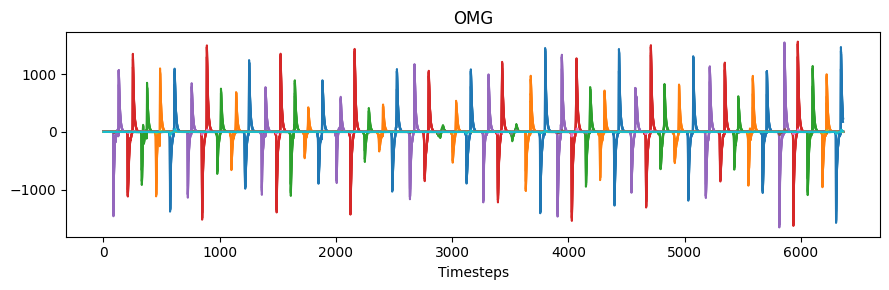

In [4]:
fig = plt.figure(figsize=(9, 3))
plt.plot(gestures[OMG_CH].values)
plt.title('OMG')
plt.xlabel('Timesteps')
plt.tight_layout()

In [5]:
# Зафиксируем данные за переменной
X = gestures[OMG_CH].values

# Перекодируем классы жестов
le = preprocessing.LabelEncoder()
state = gestures['state'].values
y_cmd = le.fit_transform(state)

display(np.c_[le.transform(le.classes_), le.classes_])

print(X.shape, y_cmd.shape)

array([[0, 'Close'],
       [1, 'Indication'],
       [2, 'Neutral'],
       [3, 'Open'],
       [4, 'Pinch'],
       [5, 'ThumbFingers']], dtype=object)

(6364, 50) (6364,)


In [6]:
GESTURES = le.classes_
GESTURES

array(['Close', 'Indication', 'Neutral', 'Open', 'Pinch', 'ThumbFingers'],
      dtype=object)

Выведем данные и таргет.

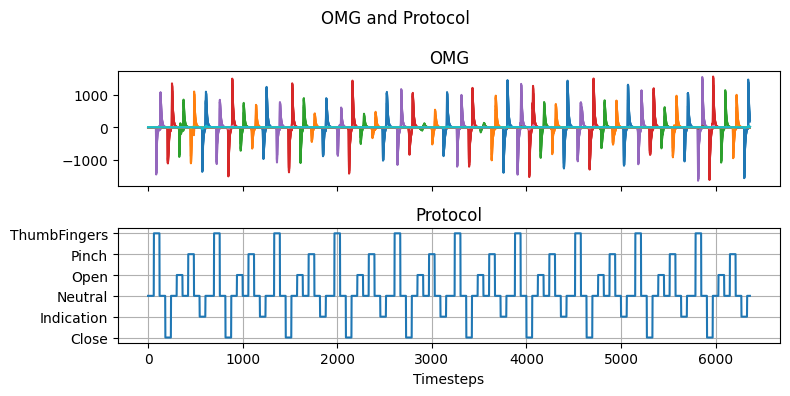

In [7]:
fig, axx = plt.subplots(2, 1, sharex=True, figsize=(8, 4))
plt.sca(axx[0])
plt.plot(gestures[OMG_CH].values)
plt.title('OMG')

plt.sca(axx[1])
plt.plot(y_cmd)
plt.grid()
plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.xlabel('Timesteps')
plt.title('Protocol')

plt.suptitle('OMG and Protocol')
plt.tight_layout()

---
## Предобработка данных

#### Функция для визуализации

In [8]:
def get_graphs(X_array, y_array, start=1000, end=1500):
    """Функция для отрисовки графики "OMG and Protocol"
    для заданного интервала

    Args:
        X_array (ndarray): массив данных.
        y_array (ndarray): вектор таргета.
        start (int, optional): стартовая точка данных
        визуализируемого интервала. Defaults to 1000.
        end (int, optional): конечная точка данных
        визуализируемого интервала. Defaults to 1500.
    """
    
    _, ax1 = plt.subplots(sharex=True, figsize=(15, 3))
    plt.suptitle(f'OMG and Protocol {start}:{end}')
    ax1.plot(X_array[start:end])
    ax1.set_xlabel('Timesteps')
    ax1.set_ylabel('OMG')
    plt.grid(axis='x')
    ax2 = ax1.twinx()
    ax2.plot(y_array[start:end], 'b-')
    ax2.set_ylabel('y_cmd')
    plt.yticks(np.arange(len(GESTURES)), GESTURES)
    plt.show()

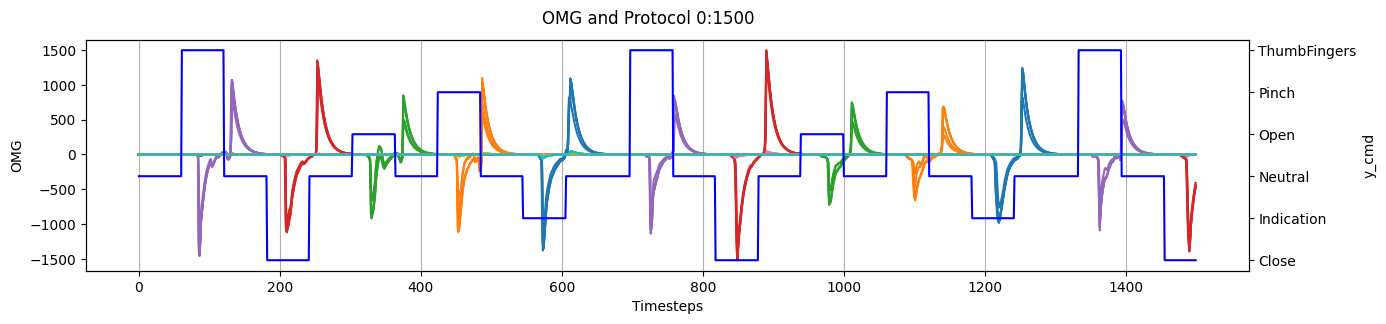

In [9]:
get_graphs(gestures[OMG_CH].values, y_cmd, start=0, end=1500)

Здесь, как и в прошлые разы, мы видим смещение данных относительно таргета. Этой особенностью, очевидно, обладают данные всех трех сетов.

#### Функция для устранение лага между сигналами датчиков и таргетом

In [10]:
def get_naive_centering(X_arr, y_arr, gap=500, inter=1000, window=20, use_m=True, model=svm.SVC()):
    """Функция для устранения глобального лага между сигналами датчиков и таргетом.

    Args:
        X_arr (ndarray): Массив данных.
        y_arr (ndarray): Вектор целевого признака.
        gap (int, optional): Размеры концевых отступов. Defaults to 500.
        inter (int, optional): Величина концевых выборок. Defaults to 1000.
        window (int, optional): Величина окна поиска оптимального сдвига. Defaults to 20.
        use_m (bool, optional): Использование модели для поиска оптимального сдвига.
            Defaults to True. False: поиск сдвига по корреляции таргета с вектором
            суммы модулей дифференциалов векторов признаков массива данных.
        model (_type_, optional): Алгоритм scikit-learn. Defaults to svm.SVC().

    Returns:
        tuple():
            ndarray: Вектор сдвинутого таргета.
            list: Строки отчета по проделанным операциям.
    """
    # part of the data from the beginning
    X_part1 = X_arr[gap:gap+inter]
    y_part1 = y_arr[gap:gap+inter]
    # part of the data from the end
    X_part2 = X_arr[-gap-inter:-gap]
    y_part2 = y_arr[-gap-inter:-gap]
    
    # Функция для сдвига таргета
    def shifter(y_arr, shift=1):
        first_element = y_arr[0]
        prefix = np.full(shift, first_element)
        y_arr_shifted = np.concatenate((prefix, y_arr))[:-shift]
    
        return y_arr_shifted
    
    # Функция для расчета точности модели
    def get_score(X, y, model=model):
        model.fit(X, y)
        preds = model.predict(X)
        
        return metrics.accuracy_score(y, preds)
    
    # Функция для расчета корреляции
    def get_corr(X, y):
        x_diff = pd.DataFrame(X).diff().abs().sum(axis=1)
        correlation = np.corrcoef(x_diff, y)[0, 1]
        
        return abs(correlation)
    
    
    max_score1, current_score1 = 0, 0
    max_score2, current_score2 = 0, 0
    s1, s2 = 1, 1
    
    for i in range(1, window+1):
        y_a = shifter(y_part1, shift=i)
        y_b = shifter(y_part2, shift=i)
        
        if use_m:
            current_score1 = get_score(X_part1, y_a)
            current_score2 = get_score(X_part2, y_b)
        else:
            current_score1 = get_corr(X_part1, y_a)
            current_score2 = get_corr(X_part2, y_b)
        
        if current_score1 > max_score1:
            max_score1, current_score1 = current_score1, max_score1
            s1 = i
        
        if current_score2 > max_score2:
            max_score2, current_score2 = current_score2, max_score2
            s2 = i
    
    optimal_shift = round((s1+s2)/2)
    y_arr_shifted = shifter(y_arr, shift=optimal_shift)
    summary = [
        f'Оптимальные свдиги для концевых выборок:   {s1} и {s2}\n',
        f'Accuracy/correlation на концевых выборках: {max_score1}; {max_score2}\n',
        f'Размер оптимального сдвига (как среднего): {optimal_shift}'
    ]
    
    return y_arr_shifted, summary

### Сэмплирование

Здесь мы начнем накапливать сэмплы для тестирования данных. Для этого мы напишем специальную функцию, которая подгрузит данные (1), избавится от сдвига таргета (2), сформирует выборки данных (3) и разместит их в словаре (4). Всего будет три словаря — по числу сетов.

Важно попытаться сохранить равное представительство классов жестов внутри каждой из выборок, т.е. число каждого вида жестов внутри выборки долнжо быть одинаковым. Для данных из третьего сета соотношение 80/20 не подходит, поэтому там был подобран индекс отсечения.

In [11]:
def get_dict_with_data(file_path, get_data_only=False):
    """Функция для загрузки данных и помещения их в словарь.

    Args:
        file_path (str): путь до файла
        get_y_only (bool, optional): опция для получения только
        вектора целевого признака. Defaults to False.

    Returns:
        dict: словарь
        ndarray: вектор целевого признака, если get_y_only=True.
    """
    # Создадим словарь 
    dictionary = dict()
    OMG_CH = np.arange(50).astype(str)
    # Подгружаем таблицу с данными
    data = pd.read_csv(file_path, sep=' ', on_bad_lines='skip')
    # Далее мы избавляемся от начального и конечного участков записи данных
    data = data[~data['state'].isin(['Baseline', 'Finish'])]
    # ...и разбираемся со смещенными индексами
    data.sort_index(inplace=True)
    data.reset_index(drop=True, inplace=True)
    
    # Зафиксируем данные за переменной
    X = data[OMG_CH].values

    # Перекодируем классы жестов
    le = preprocessing.LabelEncoder()
    state = data['state'].values
    y_cmd = le.fit_transform(state)
    
    y_shifted, _ = get_naive_centering(X, y_cmd, gap=20, inter=100, window=30, use_m=False)
    
    if get_data_only:
        return X, y_shifted
    
    if '2024-03-04_11-11-02' not in file_path:
        X_train = X[:int(X.shape[0] * 0.8)+1]
        X_valid = X[int(X.shape[0] * 0.8)+1:]

        y_train = y_shifted[:int(X.shape[0] * 0.8)+1]
        y_valid = y_shifted[int(X.shape[0] * 0.8)+1:]
    else:
        X_train = X[:1950]
        X_valid = X[1950:]

        y_train = y_shifted[:1950]
        y_valid = y_shifted[1950:]
    
    # Занесем в словарь наши данные
    key = 'original_data'
    dictionary[key] = [X_train, X_valid, y_train, y_valid]

    return dictionary

Создадим три словаря и соберем их в список, а затем распечатаем shapы данных под ключами словарей.

In [12]:
dictionary_0 = get_dict_with_data(palm_files[0])
dictionary_1 = get_dict_with_data(palm_files[1])
dictionary_2 = get_dict_with_data(palm_files[2])

dictionaries = [dictionary_0, dictionary_1, dictionary_2]

for dictionary in dictionaries:
    for key in list(dictionary.keys()):
        print(f"{str(key).capitalize().replace('_', ' ')} shapes:")
        print('Train:', dictionary[key][0].shape, dictionary[key][2].shape)
        print('Test: ', dictionary[key][1].shape, dictionary[key][3].shape)
        print()

Original data shapes:
Train: (5092, 50) (5092,)
Test:  (1272, 50) (1272,)

Original data shapes:
Train: (5092, 50) (5092,)
Test:  (1272, 50) (1272,)

Original data shapes:
Train: (1950, 50) (1950,)
Test:  (595, 50) (595,)



Посмотрим на данные всех трех сетов.

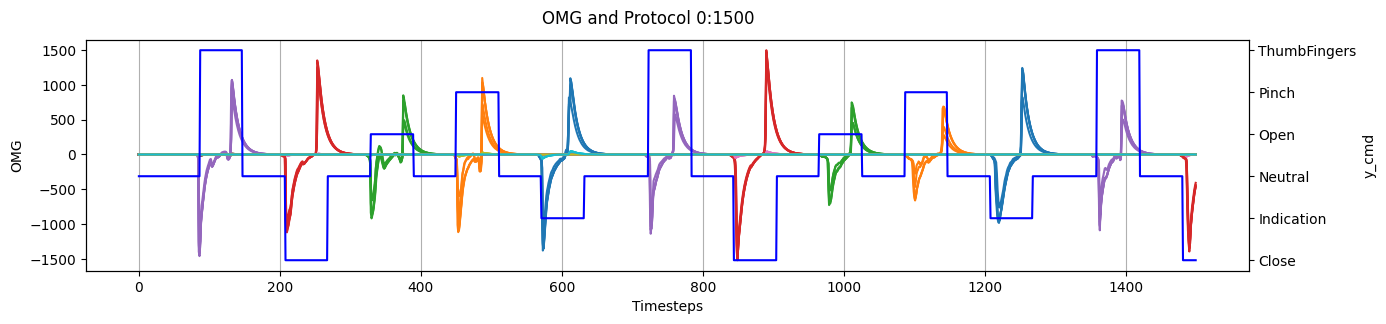

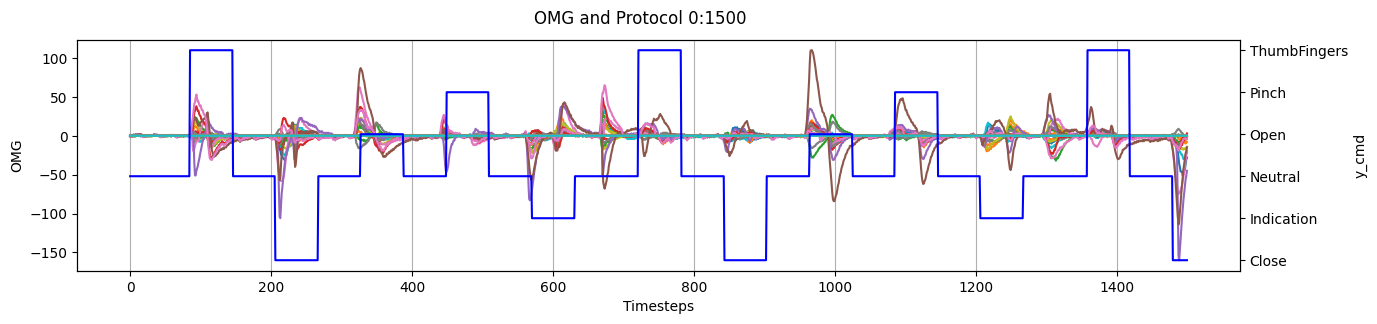

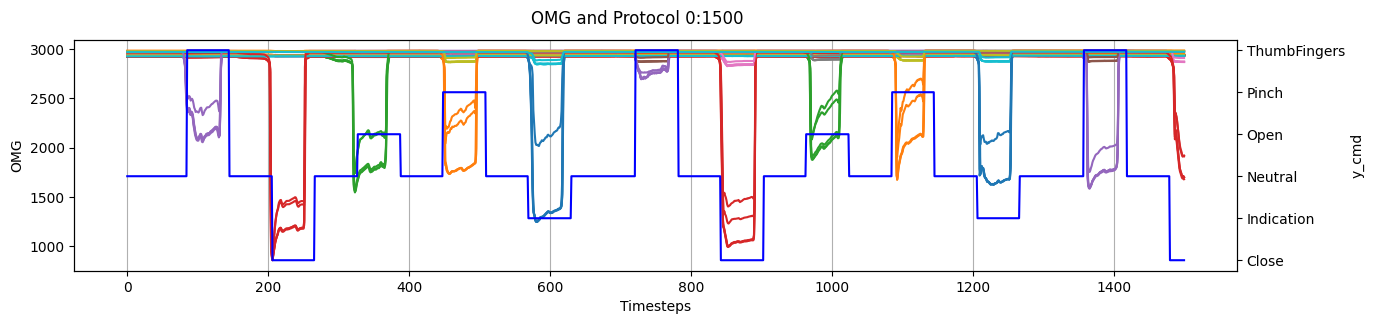

In [162]:
for i in range(3):
    get_graphs(
        dictionaries[i][list(dictionaries[0].keys())[0]][0],
        dictionaries[i][list(dictionaries[0].keys())[0]][2],
        start=0, end=1500
    )

Что-то они довольно сильно отличаются друг от друга.

### Оценка доли нулей

В этом подразделе осуществляется визуализация нулевых строк в данных и подсчет их доли в признаках. Это может быть полезным, если мы желаем предварительно оценить вклад признаков в предсказания обучаемых моделей.

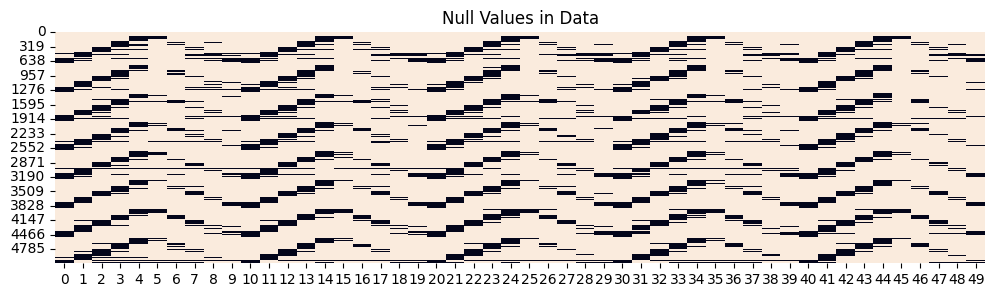

In [13]:
def get_null_map(dict_idx):
    """Функция для визуализации нулей в данных

    Args:
        dict_idx (int): индекс словаря в списке.
    """
    null_detect = pd.DataFrame(
        dictionaries[dict_idx]['original_data'][0],columns=[*OMG_CH]
    ).replace(0, np.nan)

    # Создадим тепловую карту для визуализации 0-значений
    plt.figure(figsize=(12, 3))
    sns.heatmap(null_detect.isna(), cbar=False)
    plt.title('Null Values in Data')
    plt.show()
    

get_null_map(0)

Очень интересное распределение нулей в данных. Мы видим, что ненулевые строки коррелируют с сериями жестов, а признаки поделились на пять групп, по паре признаков в которых *реагируют* только на свои жесты.

Любопытно, но подобная картина наблюдается только для первого сета.

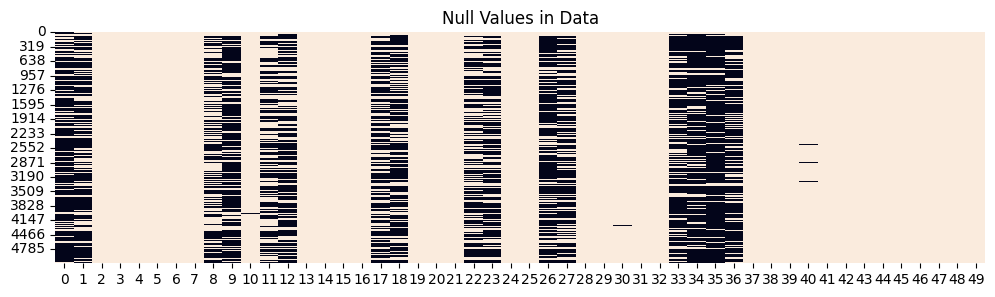

In [14]:
get_null_map(1)

Это второй сет, где, как мы видим, присутствуют полностью обнуленные признаки. Забегая вперед, отметим, что этот сет хуже всего поддается моделированию.

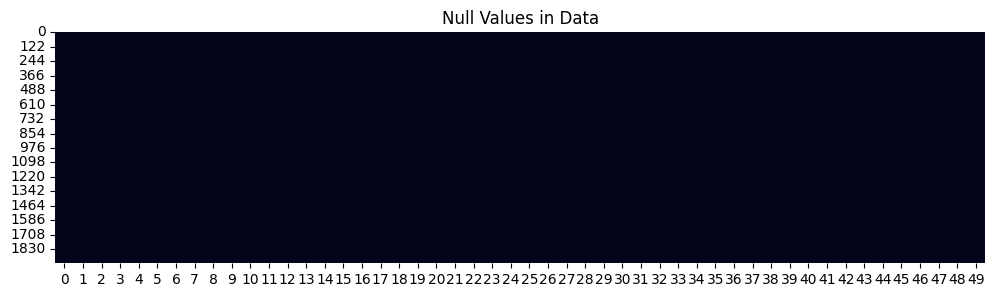

In [15]:
get_null_map(2)

Это третий сет, и в нем ни единого нуля.

Такая разность распределения или наличия нулевых значений может говорить как о разности в методологиях сбора данных, так и о наличии постобработки — специалисты Моторики не дали разъясняющих комментарий на этот счет, но и стажеры, надо полагать, не успели как следует обдумать необходимость на этом настоять.

### Нормализация и стандартизация

In [16]:
# Инициализируем методы нормализации и стандартизации
normalizer = preprocessing.Normalizer()
rb_scaler = preprocessing.RobustScaler()
mm_scaler = preprocessing.MinMaxScaler()
st_scaler = preprocessing.StandardScaler()
scalers = [normalizer, rb_scaler, mm_scaler, st_scaler]
prfix_list = ['_norm', '_rb', '_mm', '_st']

# Занесем в каждый словарь предобработанные версии данных
for dictionary in dictionaries:
    for key in list(dictionary.keys()):
        train_y = dictionary[key][2]
        valid_y = dictionary[key][3]
        
        for i, scaler in enumerate(scalers):
            X_train_scaled = scaler.fit_transform(dictionary[key][0])
            X_valid_scaled = scaler.transform(dictionary[key][1])
            new_key = f'data{prfix_list[i]}'
            dictionary[new_key] = [
                X_train_scaled, X_valid_scaled, train_y, valid_y
            ]

Выведем новые наборы ключей.

In [17]:
for dictionary in dictionaries:
    print(dictionary.keys())

dict_keys(['original_data', 'data_norm', 'data_rb', 'data_mm', 'data_st'])
dict_keys(['original_data', 'data_norm', 'data_rb', 'data_mm', 'data_st'])
dict_keys(['original_data', 'data_norm', 'data_rb', 'data_mm', 'data_st'])


### Генерация признаков
#### Аппроксимирующая модель линейной регрессии

In [19]:
def get_approx_lr_coefs(X, n_ftrs=10, prev=None, lin_alg=None):
    """Функция для формирования признакового описания 
       с использованием линейной регрессии

    Args:
        X (ndarray): массив данных.
        n_ftrs (int, optional): размер сэмпла. Defaults to 10.
        prev (ndarray, optional): предшествующие данные размером n_ftrs.
        Defaults to None.
        lin_alg (abc.ABCMeta, optional): линейный алгоритм sklearn.
        По умолчанию используется алгоритм МНК из numpy.

    Returns:
        ndarray: массив коэффициентов модели регрессии.
    """
    
    def get_coefs(data):
        # Разделение данных на признаки и целевую переменную
        segments_X = data[1:, :].T
        segments_y = data[0, :]
        
        # Обучение модели линейной регрессии
        if lin_alg is not None:
            model = lin_alg()
            model.fit(segments_X, segments_y)
            # Получение параметров модели
            return model.coef_
        else:
            w = np.linalg.lstsq(segments_X, segments_y, rcond=None)[0]
            # Вектор весов линейной функции
            return w
        
    
    w_g = np.zeros((0, n_ftrs))
    window = np.zeros((n_ftrs+1, X.shape[-1]))
    if prev is not None:
        window[1:, :] = prev
    
    for i in range(X.shape[0]):
        if not np.sum(window[0]):
            window[0, :] = X[i]
        else:
            window[1:, :] = window[:-1, :]
            window[0, :] = X[i]

        coefs = get_coefs(window)
        w_g = np.vstack((w_g, coefs))
    
    return w_g

In [20]:
# Занесем в каждый словарь предобработанные версии данных
for dictionary in dictionaries:
    for key in tqdm(list(dictionary.keys()), desc="Processed"):
        train_y = dictionary[key][2]
        valid_y = dictionary[key][3]
        
        X_train_ax = get_approx_lr_coefs(dictionary[key][0], n_ftrs=5)
        X_valid_ax = get_approx_lr_coefs(dictionary[key][1], n_ftrs=5)
        
        new_key = key + '_ax'
        dictionary[new_key] = (X_train_ax, X_valid_ax, train_y, valid_y)

Processed: 100%|██████████| 5/5 [00:00<00:00, 20.76it/s]


In [21]:
for dictionary in dictionaries:
    print(list(dictionary.keys())[:-5])
    print(list(dictionary.keys())[-5:])

['original_data', 'data_norm', 'data_rb', 'data_mm', 'data_st']
['original_data_ax', 'data_norm_ax', 'data_rb_ax', 'data_mm_ax', 'data_st_ax']
['original_data', 'data_norm', 'data_rb', 'data_mm', 'data_st']
['original_data_ax', 'data_norm_ax', 'data_rb_ax', 'data_mm_ax', 'data_st_ax']
['original_data', 'data_norm', 'data_rb', 'data_mm', 'data_st']
['original_data_ax', 'data_norm_ax', 'data_rb_ax', 'data_mm_ax', 'data_st_ax']


#### Аппроксимирующая модель авторегрессии

In [22]:
def get_ar_coefs(array, p=5, prev=None):
    """Функция для генерации новых признаков на основе векторов
    оптимальных параметров модели авторегрессии.

    Args:
        array (ndarray): массив данных.
        p (int, optional): размер базы аппроксимации. Defaults to 5.
        prev (ndarray): массив данных для аппроксимации первой точки.
        Defaults to None.

    Returns:
        ndarray: массив сгенерированных признаков на основе
        рассчитанных коэффициентов.
    """
    new_features = np.zeros((array.shape[0],0))
    
    # Проходим внешним циклом по переменным (столбцам) в данных
    for i in range(array.shape[1]):
        if prev is None:
            data = np.hstack((np.zeros(p), array[:, i]))
        else:
            data = np.hstack((prev[:, i], array[:, i]))
        t = len(data)
        w_massive = np.zeros((0, p+1))
        
        # Проходим внутренним циклом по вектору значений переменного
        for j in range(p, t):
            features = data[j-p:j]
            labels = np.array(data[j]).reshape(-1, 1)
        
            # Решение системы уравнений методом наименьших квадратов
            X = np.hstack((np.ones(1), features)).reshape(1, -1)
            w = np.linalg.lstsq(X, labels, rcond=None)[0]
            
            w_massive = np.vstack((w_massive, w.reshape(1, -1)))
            
        # Собираем в единый массив параметры МНК
        new_features = np.hstack((new_features, w_massive))
        
    return new_features

In [23]:
# Занесем в каждый словарь предобработанные версии данных
for dictionary in dictionaries:
    for key in tqdm(list(dictionary.keys())[:5], desc="Processed"):
        train_y = dictionary[key][2]
        valid_y = dictionary[key][3]
        
        X_train_ar = get_ar_coefs(dictionary[key][0])
        X_valid_ar = get_ar_coefs(dictionary[key][1])
        
        new_key = key + '_ar'
        dictionary[new_key] = (X_train_ar, X_valid_ar, train_y, valid_y)

Processed: 100%|██████████| 5/5 [00:08<00:00,  1.64s/it]


In [24]:
for dictionary in dictionaries:
    print(list(dictionary.keys())[:5])
    print(list(dictionary.keys())[5:10])
    print(list(dictionary.keys())[10:])

['original_data', 'data_norm', 'data_rb', 'data_mm', 'data_st']
['original_data_ax', 'data_norm_ax', 'data_rb_ax', 'data_mm_ax', 'data_st_ax']
['original_data_ar', 'data_norm_ar', 'data_rb_ar', 'data_mm_ar', 'data_st_ar']
['original_data', 'data_norm', 'data_rb', 'data_mm', 'data_st']
['original_data_ax', 'data_norm_ax', 'data_rb_ax', 'data_mm_ax', 'data_st_ax']
['original_data_ar', 'data_norm_ar', 'data_rb_ar', 'data_mm_ar', 'data_st_ar']
['original_data', 'data_norm', 'data_rb', 'data_mm', 'data_st']
['original_data_ax', 'data_norm_ax', 'data_rb_ax', 'data_mm_ax', 'data_st_ax']
['original_data_ar', 'data_norm_ar', 'data_rb_ar', 'data_mm_ar', 'data_st_ar']


### Комбинирование методов предобработки

In [25]:
# Занесем в каждый словарь предобработанные версии данных
for dictionary in tqdm(dictionaries, desc="Processed"):
    keys_list = list(dictionary.keys())
    train_y = dictionary[keys_list[0]][2]
    valid_y = dictionary[keys_list[0]][3]
    new_dictionary = {}
    for i in range(5):
        for suffix, indices in [
            ('_ax_', [i, i+5]), ('_ar_', [i, i+10]),
            ('_ax_ar', [i+5, i+10]), ('_ax_ar_', [i, i+5, i+10])
            ]:
            X_train = np.hstack([dictionary[keys_list[i]][0] for i in indices])
            X_valid = np.hstack([dictionary[keys_list[i]][1] for i in indices])
            new_key = keys_list[indices[0]].split('_')[1] + suffix
            new_dictionary[new_key] = [X_train, X_valid, train_y, valid_y]
        
    dictionary.update(new_dictionary)

Processed: 100%|██████████| 3/3 [00:00<00:00, 21.36it/s]


In [26]:
for dictionary in dictionaries[:1]:
    print(list(dictionary.keys())[:5])
    print(list(dictionary.keys())[5:10])
    print(list(dictionary.keys())[10:15])
    print(list(dictionary.keys())[15:19])
    print(list(dictionary.keys())[19:23])
    print(list(dictionary.keys())[23:27])
    print(list(dictionary.keys())[27:31])
    print(list(dictionary.keys())[31:35])

['original_data', 'data_norm', 'data_rb', 'data_mm', 'data_st']
['original_data_ax', 'data_norm_ax', 'data_rb_ax', 'data_mm_ax', 'data_st_ax']
['original_data_ar', 'data_norm_ar', 'data_rb_ar', 'data_mm_ar', 'data_st_ar']
['data_ax_', 'data_ar_', 'data_ax_ar', 'data_ax_ar_']
['norm_ax_', 'norm_ar_', 'norm_ax_ar', 'norm_ax_ar_']
['rb_ax_', 'rb_ar_', 'rb_ax_ar', 'rb_ax_ar_']
['mm_ax_', 'mm_ar_', 'mm_ax_ar', 'mm_ax_ar_']
['st_ax_', 'st_ar_', 'st_ax_ar', 'st_ax_ar_']


### Понижение размерности

In [27]:
# Занесем в каждый словарь предобработанные версии данных
for dictionary in dictionaries:
    keys_list = list(dictionary.keys())
    train_y = dictionary[keys_list[0]][2]
    valid_y = dictionary[keys_list[0]][3]
    new_dictionary = {}

    for key in tqdm(keys_list, desc="Processed"):
        train, valid, _, _ = dictionary[key]
        pca = decomposition.PCA(n_components=0.9999, random_state=42).fit(train)
        train_pca = pca.transform(train)
        valid_pca = pca.transform(valid)
        new_key = 'pca_' + key
        new_dictionary[new_key] = [train_pca, valid_pca, train_y, valid_y]
        
    dictionary.update(new_dictionary)

Processed: 100%|██████████| 35/35 [00:02<00:00, 15.96it/s]


### Экспоненциальное сглаживаение

In [28]:
# Функция для экспоненциального сглаживания
def get_smoothing(Xdf, sample_size=5, alpha=0.5):
    """Функция для экспоненциального сглаживания

    Args:
        Xdf (ndarray): Массив данных.
        sample_size (int, optional): Размер сглаживаемой выборки. Defaults to 5.
        alpha (float, optional): Коэффициент сглаживания. Defaults to 0.3.

    Returns:
        ndarray: Преобразованный массив.
    """
    samples, j = [], 0
    for i in range(sample_size, Xdf.shape[0] + 1, sample_size):
        x_smoothed = Xdf.loc[j:i-1, list(Xdf.columns)].ewm(alpha=alpha, adjust=True).mean().values
        samples.append(x_smoothed)
        j = i
    
    X_ewm = np.row_stack(samples)
    
    return X_ewm

In [29]:
# Занесем в каждый словарь предобработанные версии данных
for dictionary in dictionaries:
    keys_list = list(dictionary.keys())
    train_y = dictionary[keys_list[0]][2]
    valid_y = dictionary[keys_list[0]][3]
    new_dictionary = {}

    for key in tqdm(keys_list, desc="Processed"):
        train, valid, _, _ = dictionary[key]
        es_train = get_smoothing(pd.DataFrame(train), sample_size=10, alpha=0.3)
        es_valid = get_smoothing(pd.DataFrame(valid), sample_size=10, alpha=0.3)
        diff1 = train.shape[0] - es_train.shape[0]
        diff2 = valid.shape[0] - es_valid.shape[0]
        zeros_array1 = np.zeros((diff1, train.shape[1]))
        zeros_array2 = np.zeros((diff2, valid.shape[1]))
        es_train = np.vstack((es_train, zeros_array1))
        es_valid = np.vstack((es_valid, zeros_array2))
        new_key = 'es_' + key
        new_dictionary[new_key] = [es_train, es_valid, train_y, valid_y]

    dictionary.update(new_dictionary)

Processed: 100%|██████████| 70/70 [00:27<00:00,  2.57it/s]


---
## Моделирование

### Часть 1.

В этой части мы проведем уже знакомый нам тип исследования сочетаний модель-данные: мы последовательно прогоним все типы данных через алгоритмы, измерим метрики и сформируем топ лучших комбинаций.

Соберем зоопарк алгоритмов:

In [30]:
# Линейная регрессия
lr = linear_model.LogisticRegression(
    solver='liblinear',
    max_iter=10000,
    random_state=42
)

# Пассивно-агрессивный классификатор
pac = linear_model.PassiveAggressiveClassifier(random_state=42)

# Простой перцептрон
pct = linear_model.Perceptron(random_state=42)

# Линейный классификатор на стохастическом градиентном спуске
sgdc = linear_model.SGDClassifier(random_state=42)

# Линейный классификатор на опорных векторах
lsvc = svm.LinearSVC(
    dual='auto',
    random_state=42,
    max_iter=2000
)

# Метод опорных векторов
svc = svm.SVC(random_state=42)

# Классификатор на k-ближайших соседях
knc = neighbors.KNeighborsClassifier()

# Многослойный перцептрон
mlpc = neural_network.MLPClassifier(
    max_iter=2000,
    random_state=42
)

# Простой бэггинг на деревьях решений
bc = ensemble.BaggingClassifier(
    estimator=tree.DecisionTreeClassifier(),
    n_jobs=-1,
    random_state=42
)

# Классификатор чрезвычайно рандомизированных деревьев
etc = ensemble.ExtraTreesClassifier(
    n_jobs=-1,
    random_state=42
)

# Лес случайных деревьев
rfc = ensemble.RandomForestClassifier(
    n_jobs=-1,
    random_state=42
)

# Градиентный бустинг на гистограммах
hgbc = ensemble.HistGradientBoostingClassifier(random_state=42)

# Крутой градиентный бустинг :)
xgbc = xgb.XGBClassifier(seed=42, n_jobs=-1)

# Градиентный бустинг от Microsoft
lgbmc = lgbm.LGBMClassifier(
    objective='multiclass',
    seed=42
)

# Градиентный бустинг от Яндекс
cbc = cb.CatBoostClassifier(verbose=False, random_seed=42)

Объединим их в один список.

In [31]:
models = [
    lr, pac, pct, sgdc, lsvc, svc, knc, mlpc, 
    bc, etc, rfc, hgbc, xgbc, lgbmc, cbc
]

На этот раз мы немного модернизируем наш подход и попробуем собрать 3d-массив данных, где по высоте будут отложены типы данных, по ширине — алгоритмы, в глубину — плоскости с метриками по каждому жесту.

In [32]:
def get_report_massive(dictionary):
    """Функция для получения массива отчета по прогону данных, хранящихся в словаре.

    Args:
        dictionary (dict): словарь с данными.

    Returns:
        ndarray: 3d-массив метрик f1 по каждому набору данных из словаря.
    """
    n_metrics = len(['f1_weighted', *GESTURES])
    n_samples = len(dictionary.keys())
    n_models = len(models)
    
    massive = np.zeros((n_metrics, n_samples, n_models))
    i = 0
    for model in tqdm(models, desc="Processed"):
        for j in range(140):
            train_X, valid_X, train_y, valid_y = dictionary[list(dictionary.keys())[j]]
            model.fit(train_X, train_y)
            preds_valid = model.predict(valid_X)
            for k in range(massive.shape[0]):
                if k == 0:
                    massive[k][j][i] = metrics.f1_score(valid_y, preds_valid, average='weighted')
                else:
                    massive[k][j][i] = metrics.f1_score(valid_y, preds_valid, average=None)[k-1]
        i += 1
    
    return massive

Отключаем предупреждения ConvergenceWarning, сообщающую о несходимости функции оптимизации и о необходимости увеличить максимальное число итераций. Существуют случаи, когда это делать бесполезно, а мы еще вынуждены прерывать и перезапускать циклы.

In [33]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)

Запустим генерацию отчетов.

In [34]:
# report_massive1 = get_report_massive(dictionaries[0])
# report_massive2 = get_report_massive(dictionaries[1])
# report_massive3 = get_report_massive(dictionaries[2])

Processed: 100%|██████████| 15/15 [1:43:10<00:00, 412.68s/it] 


Результаты мы, разумеется, сохраним, а код закоммитим, чтобы избежать повторного запуска и перезаписи данных.

In [34]:
# np.save(
#     f"""derivatives/new_data_reports/{
#         palm_files[0].split("/")[-1].split(".")[0]
#         }_report_massive.npy""",
#     report_massive1)
# np.save(
#     f"""derivatives/new_data_reports/{
#         palm_files[1].split("/")[-1].split(".")[0]
#         }_report_massive.npy""",
#     report_massive2)
# np.save(
#     f"""derivatives/new_data_reports/{
#         palm_files[2].split("/")[-1].split(".")[0]
#         }_report_massive.npy""",
#     report_massive3)

# Подгрузим отчеты
loaded_report_massive1 = np.load(
    'derivatives/new_data_reports/2024-03-04_08-17-49_report_massive.npy'
)
loaded_report_massive2 = np.load(
    'derivatives/new_data_reports/2024-03-04_10-00-21_report_massive.npy'
)
loaded_report_massive3 = np.load(
    'derivatives/new_data_reports/2024-03-04_11-11-02_report_massive.npy'
)

In [41]:
# Соберем в список имена алгоритмов
alg_names = [
    'LR', 'PAC', 'Pct', 'SGDC', 'LSVC', 'SVC', 'KNC', 'MLPC',
    'BC', 'ETC', 'RFC', 'HGBC', 'XGBC', 'LGBMC', 'CBC'
]

# Объединим отчеты в список
reports_list = [
    loaded_report_massive1,
    loaded_report_massive2,
    loaded_report_massive3
]


def get_reports_tops(i=5):
    """Функция для вывода топов по каждому сету.

    Args:
        i (int, optional): величина списка. Defaults to 5.
    """
    # Пройдемся в цикле по отчетам и распечатаем топ-5 комбинаций для каждого из сетов
    for j in range(3):
        report_df = pd.DataFrame(
            data=[row.flatten() for row in reports_list[j][0, :, :]],
            columns=alg_names,
            index=list(dictionaries[0].keys())
        )
        
        # Составим топ алгоритмов
        top_values = report_df.stack().nlargest(i)  # Получаем топ-i наибольших значений в датафрейме
        for index, value in top_values.items():  # Перебираем полученные значения и их индексы
            row, col = index  # Получаем индекс строки и столбца
            print(f"Индекс: {row}".ljust(22), f"| Алгоритм: {col}".ljust(17), f"| Метрика: {round(value, 4)}")
        
        if i !=2:
            print('-'*60)
            
get_reports_tops()

Индекс: es_mm_ax_ar_   | Алгоритм: RFC   | Метрика: 0.9545
Индекс: mm_ax_ar_      | Алгоритм: ETC   | Метрика: 0.9529
Индекс: es_mm_ax_ar    | Алгоритм: ETC   | Метрика: 0.9528
Индекс: data_mm_ar     | Алгоритм: CBC   | Метрика: 0.9522
Индекс: es_mm_ax_ar    | Алгоритм: XGBC  | Метрика: 0.9522
------------------------------------------------------------
Индекс: es_mm_ax_ar    | Алгоритм: XGBC  | Метрика: 0.873
Индекс: es_norm_ax_ar  | Алгоритм: HGBC  | Метрика: 0.8707
Индекс: es_norm_ax_ar_ | Алгоритм: HGBC  | Метрика: 0.8706
Индекс: es_data_mm_ar  | Алгоритм: CBC   | Метрика: 0.8697
Индекс: es_norm_ax_ar  | Алгоритм: LGBMC | Метрика: 0.8697
------------------------------------------------------------
Индекс: es_data_mm_ar  | Алгоритм: RFC   | Метрика: 0.947
Индекс: es_mm_ax_ar    | Алгоритм: RFC   | Метрика: 0.947
Индекс: es_data_st_ar  | Алгоритм: ETC   | Метрика: 0.9459
Индекс: es_mm_ar_      | Алгоритм: RFC   | Метрика: 0.9453
Индекс: es_mm_ax_ar_   | Алгоритм: RFC   | Метрика: 0.9

Здорово! У нас уже имеются неплохие результаты. Далее модели можно пробовать оптимизировать, но для этого нам нужно выделить еще одну выборку: нам, напомним, необходимо следовать принципу равной представительности классов жестов в выборках.

### Часть 2.

Здесь проводятся отдельные испытания алгоритмов, а также их оптимизация. Но сперва разберемся с выборками.

In [36]:
# Воспользуемся дополнительной опцией функции подгрузки данных
X_0, target_0 = get_dict_with_data(palm_files[0], get_data_only=True)
X_1, target_1 = get_dict_with_data(palm_files[1], get_data_only=True)
X_2, target_2 = get_dict_with_data(palm_files[2], get_data_only=True)

targets = target_0.shape, target_1.shape, target_2.shape
targets

((6364,), (6364,), (2545,))

Выведем целевые признаки и подберем индексы разделения выборок.

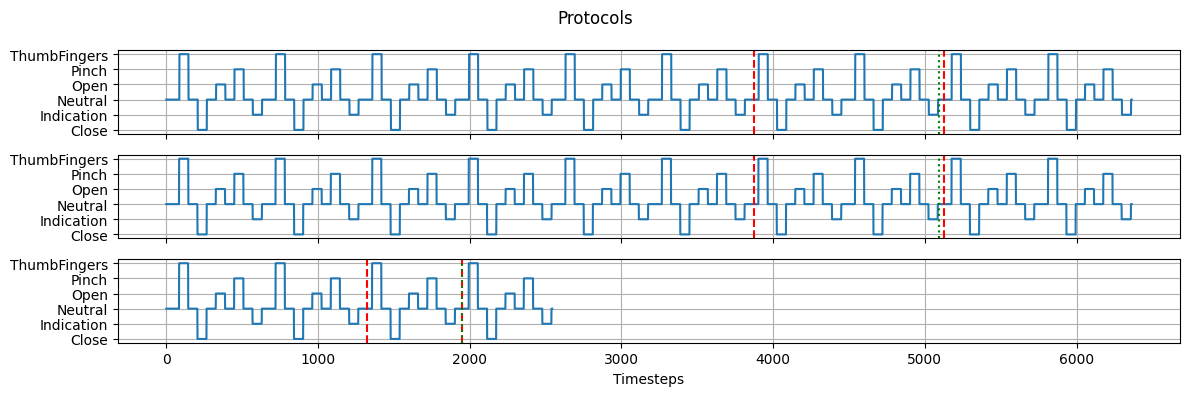

In [37]:
fig, axx = plt.subplots(3, 1, sharex=True, figsize=(12, 4))

plt.sca(axx[0])
plt.plot(target_0)
plt.grid()
plt.yticks(np.arange(len(GESTURES)), GESTURES)
axx[0].axvline(x=5125, color='red', linestyle='--')
axx[0].axvline(x=3875, color='red', linestyle='--')
axx[0].axvline(x=target_0.shape[0]*0.8, color='green', linestyle=':')

plt.sca(axx[1])
plt.plot(target_1)
plt.grid()
plt.yticks(np.arange(len(GESTURES)), GESTURES)
axx[1].axvline(x=5125, color='red', linestyle='--')
axx[1].axvline(x=3875, color='red', linestyle='--')
axx[1].axvline(x=target_1.shape[0]*0.8, color='green', linestyle=':')

plt.sca(axx[2])
plt.plot(target_2)
plt.grid()
plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.xlabel('Timesteps')
axx[2].axvline(x=1950, color='red', linestyle='--')
axx[2].axvline(x=1325, color='red', linestyle='--')
axx[2].axvline(x=1950, color='green', linestyle=':')

plt.suptitle('Protocols')
plt.tight_layout()

Зеленая пунктирная линия — сэмплирование из первой части раздела (без валидационной выборки).

Данных первых двух сетов, как видим, вполне достаточно, чтобы выделить три выборки, но с третьим сетом ситуация посложнее: треннировочная выборка составит лишь 50% от исходного ряда.

К высокой метрике моделей, обученных на данных третьего сета, вообще стоит относиться скептически: данных просто мало, и мы не можем быть вполне уверены в том, что длительности временного ряда достаточно, чтобы обучить адекватную модель, способную улавливать изменения жестов во всех нелабораторных условиях. Однако, пожалуй, это замечание с разной степенью будет справедливо в отношении любого из сетов — даже старых. Но работаем с тем, что имеется!

In [38]:
# Разобьем на выборки векторы целевых признаков
y_train_0, y_valid_0, y_test_0 = target_0[:3875], target_0[3875:5125], target_0[5125:]
y_train_1, y_valid_1, y_test_1 = target_1[:3875], target_1[3875:5125], target_1[5125:]
y_train_2, y_valid_2, y_test_2 = target_2[:1325], target_2[1325:1950], target_2[1950:]

targets_0 = [y_train_0, y_valid_0, y_test_0]
targets_1 = [y_train_1, y_valid_1, y_test_1]
targets_2 = [y_train_2, y_valid_2, y_test_2]
targets_lst = [targets_0, targets_1, targets_2]

С целевыми признаками все просто, но вот предобработанные данные, хранящиеся в словарях под удобными ключями, уже разделены на треннировочную и валидационную выборки. Нам придется произвести над ними дополнительную работу.

In [39]:
def two2three_samples(lst_of_2_samples, lti=3875, lvi=5125):
    """Функция для сэмплирования данных на три выборки.

    Args:
        lst_of_2_samples (list): _description_
        lti (int, optional): last train index. Defaults to 3875.
        lvi (int, optional): last valid index. Defaults to 5125.

    Returns:
        tuple: кортеж из трех выборок
    """
    X = np.vstack((lst_of_2_samples[0], lst_of_2_samples[1]))
    train, valid, test = X[:lti], X[lti:lvi], X[lvi:]
    
    return train, valid, test
    
    
# Заодно зафиксируем в переменных индексы
# отсечения выборок для третьего сета
LTI_3, LVI_3 = 1325, 1950

---
#### LogisticRegression

Сперва надо посмотреть, а как этот алгоритм прошел тест на всех трех сетах в первой части раздела.

In [42]:
def get_tops(alg_idx, n_top=3):
    """Функция для вывода рейтинга лучших данных для заданного
    индекса алгоритма в списке моделей по всем трем сетам

    Args:
        alg_idx (int): индекса алгоритма в списке моделей
        n_top (int, optional): размер выводимого списка. Defaults to 3.
    """
    for i in range(3):
        report = pd.DataFrame(
            data=[row.flatten() for row in reports_list[i][:, :, alg_idx]],
            columns=list(dictionaries[0].keys()),
            index=['f1_weighted', *GESTURES]
        ).transpose().sort_values('f1_weighted', ascending=False)
        display(report[:n_top])


print(models[0])
get_tops(0, n_top=3)

LogisticRegression(max_iter=10000, random_state=42, solver='liblinear')


,f1_weighted,Close,Indication,Neutral,Open,Pinch,ThumbFingers
es_st_ar_,0.875306,0.894515,0.887892,0.881255,0.885246,0.850394,0.825911
es_pca_st_ar_,0.874508,0.894515,0.887892,0.880597,0.885246,0.850394,0.821138
es_st_ax_ar_,0.873575,0.898305,0.865801,0.884903,0.885246,0.822581,0.834008


,f1_weighted,Close,Indication,Neutral,Open,Pinch,ThumbFingers
es_st_ax_ar,0.737986,0.669811,0.789700,0.837366,0.691667,0.376623,0.617512
es_pca_st_ax_ar,0.736979,0.660377,0.793103,0.837022,0.689076,0.376623,0.617512
es_st_ar_,0.736241,0.593607,0.707965,0.846618,0.751092,0.453039,0.571429


,f1_weighted,Close,Indication,Neutral,Open,Pinch,ThumbFingers
es_rb_ax_,0.891280,0.834951,0.867925,0.899687,0.912281,0.890756,0.909091
es_rb_ax_ar_,0.889575,0.834951,0.867925,0.897959,0.913793,0.890756,0.899083
es_data_ax_,0.889535,0.834951,0.878505,0.898911,0.900901,0.898305,0.888889


Сформируем выборки. Их удобно будет объединить в списки. Пожалуй, и для этого напишем свою функцию.

In [43]:
def get_samples_lst(key1, key2, key3):
    """Функция для формирования списка списков сэмплов.

    Args:
        key1 (str): ключ для словаря сэмплов первого сета.
        key2 (str): ключ для словаря сэмплов второго сета.
        key3 (str): ключ для словаря сэмплов третьего сета.

    Returns:
        list: список списков сэмплов.
    """
    X_train_0, X_valid_0, X_test_0 = two2three_samples(dictionaries[0][key1][:2])
    X_train_1, X_valid_1, X_test_1 = two2three_samples(dictionaries[1][key2][:2])
    X_train_2, X_valid_2, X_test_2 = two2three_samples(
        dictionaries[2][key3][:2], lti=LTI_3, lvi=LVI_3
    )

    samples_0 = [X_train_0, X_valid_0, X_test_0]
    samples_1 = [X_train_1, X_valid_1, X_test_1]
    samples_2 = [X_train_2, X_valid_2, X_test_2]
    samples_lst = [samples_0, samples_1, samples_2]
    
    return samples_lst

In [44]:
# Сбор сэмплов
samples_lst = get_samples_lst('es_st_ar_', 'es_st_ax_ar', 'es_rb_ax_')

##### Baseline

Сперва напишем функцию для вывода метрик baseline-модели. Нужно обратить внимание на то, что она отработает корректно лишь тогда, когда перед ней будут объявлены сэмплы для текущего алгоритма.

In [45]:
def get_metrics(model=None, set_idx=None):
    """Функция для вывода метрик baseline-модели

    Args:
        model (optional): baseline-модель. Defaults to None.
    """
    if model is None:
        return None
    
    def print_metrics(idx=0):
        train_x, train_y = samples_lst[idx][0], targets_lst[idx][0]
        test_x, test_y = samples_lst[idx][2], targets_lst[idx][2]
        model.fit(train_x, train_y)
        print(f'Metrics for set{idx+1}:')
        train_preds = model.predict(train_x)
        print('Train weighted f1:',
              round(metrics.f1_score(train_y, train_preds, average='weighted'), 5))
        test_preds = model.predict(test_x)
        print('Test weighted f1: ',
              round(metrics.f1_score(test_y, test_preds, average='weighted'), 5))
        if idx != 2:
            print()
    
    if set_idx is None:
        for i in range(3):
            print_metrics(idx=i)
    else:
        print_metrics(idx=set_idx)

In [46]:
# Инициализация модели
log_reg = linear_model.LogisticRegression(
    solver='liblinear',
    random_state=42
)
# Обучение и вывод метрик
get_metrics(log_reg)

Metrics for set1:
Train weighted f1: 0.89751
Test weighted f1:  0.86607

Metrics for set2:
Train weighted f1: 0.75264
Test weighted f1:  0.7145

Metrics for set3:
Train weighted f1: 0.93596
Test weighted f1:  0.88958


Стоит иметь в виду, что метрики, которые мы получаем с помощью функции `get_metrics` могут быть ниже, чем те, что были получены с помощью функции `get_tops`: все дело в том, что во втором случае сэмплирования на три выборки не проводилось, и модели при обучении видели чуть больше данных, чем модели в первом случае. Поэтому метрики оптимизированных моделей, разумеется, корректно будет сравнивать только с метриками baseline-модели.

##### Optimized

In [45]:
# # Определение функции для оптимизации
# def optuna_lr(trial, set_idx=0):
#     """Функция, обучающая модель LogisticRegression по переданным гиперпараметрам
#     Args:
#         trial : класс, от которого вызываются гиперпараметры
#         set_idx (int, optional): индекс сета. Defaults to 0.
#     Returns:
#         score(float): метрика F1-weighted
#     """
#     # Выбираем треннировочный и валидационный выборки
#     train_x, train_y = samples_lst[set_idx][0], targets_lst[set_idx][0]
#     valid_x, valid_y = samples_lst[set_idx][1], targets_lst[set_idx][1]
    
#     # Задаем пространство поиска гиперпараметров
#     C = trial.suggest_float('C', 1e-5, 1e2)
#     penalty = trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet'])
    
#     if penalty == 'elasticnet':
#         l1_ratio = trial.suggest_float('l1_ratio', 0, 1)
#     else:
#         l1_ratio = None

#     solver = trial.suggest_categorical('solver', ['newton-cg', 'lbfgs', 'liblinear', 'saga'])

#     if penalty == 'l1' and solver in ['newton-cg', 'lbfgs', 'sag']:
#         return 0.0 # 'l1' penalty is not supported by these solvers
#     elif penalty == 'elasticnet' and solver not in ['saga']:
#         return 0.0 # 'elasticnet' penalty is supported only by 'saga' solver
    
#     # Инициализация LogisticRegression с оптимизируемыми гиперпараметрами
#     clf = linear_model.LogisticRegression(
#         C=C, penalty=penalty, solver=solver,
#         l1_ratio=l1_ratio, max_iter=10000
#     )

#     # Вычисление метрики 
#     clf.fit(train_x, train_y)
#     valid_preds = clf.predict(valid_x)
#     score = metrics.f1_score(valid_y, valid_preds, average='weighted')

#     return score
    

# for i in range(3):
#     # Создание и запуск оптимизации с отображением прогресса с помощью tqdm
#     study_lr = optuna.create_study(study_name="lr_opt", direction='maximize')
#     # Подавляем логирование
#     optuna.logging.set_verbosity(optuna.logging.WARNING)
#     # Мониторим прогресс оптимизации
#     with tqdm(total=50, desc="Optimizing") as pbar:
#         def update(study, trial, set_idx=i):
#             pbar.update(1)
#         # Ищем лучшую комбинацию гиперпараметров n_trials раз
#         study_lr.optimize(optuna_lr, n_trials=50, callbacks=[update], n_jobs=-1)

#     # Получение оптимальных гиперпараметров
#     print("Лучшие гиперпараметры:", study_lr.best_params)

#     # Передаем модели коллекцию оптимальных гиперпараметров
#     log_reg_opt = linear_model.LogisticRegression(
#         **study_lr.best_params,
#         max_iter=10000,
#         random_state=42
#     )
    
#     # Обучение и вывод метрик
#     get_metrics(model=log_reg_opt, set_idx=i)
    
#     # Сохранение модели
#     joblib.dump(log_reg_opt, f"models/models_on_new_data/log_reg_opt_set{i+1}.pkl")

[I 2024-04-25 11:31:37,998] A new study created in memory with name: lr_opt
Optimizing: 100%|██████████| 50/50 [08:00<00:00,  9.61s/it]


Лучшие гиперпараметры: {'C': 40.33813016280553, 'penalty': 'l2', 'solver': 'liblinear'}
Metrics for set1:
Train weighted f1: 0.94984
Test weighted f1:  0.88229



Optimizing: 100%|██████████| 50/50 [05:36<00:00,  6.74s/it]


Лучшие гиперпараметры: {'C': 59.901671533342714, 'penalty': 'l2', 'solver': 'liblinear'}
Metrics for set2:
Train weighted f1: 0.82836
Test weighted f1:  0.7696



Optimizing: 100%|██████████| 50/50 [07:55<00:00,  9.51s/it]


Лучшие гиперпараметры: {'C': 58.803047893640624, 'penalty': 'l2', 'solver': 'liblinear'}
Metrics for set3:
Train weighted f1: 0.97273
Test weighted f1:  0.89119


Здорово, мы смогли успешно оптимизировать все модели.

---
### PassiveAggressiveClassifier

In [47]:
print(models[1])
get_tops(1, n_top=3)

PassiveAggressiveClassifier(random_state=42)


,f1_weighted,Close,Indication,Neutral,Open,Pinch,ThumbFingers
es_data_st_ar,0.899177,0.893443,0.916335,0.906464,0.955466,0.883534,0.806723
es_pca_data_st_ar,0.893081,0.872000,0.909091,0.898084,0.955466,0.910569,0.790123
data_st_ar,0.889246,0.890756,0.888031,0.891321,0.910506,0.902724,0.842520


,f1_weighted,Close,Indication,Neutral,Open,Pinch,ThumbFingers
es_data_st_ar,0.734288,0.664122,0.723810,0.834979,0.733945,0.556962,0.442211
es_pca_norm_ax_ar,0.725438,0.514620,0.710900,0.828958,0.747664,0.492147,0.595745
es_pca_data_st_ar,0.720257,0.631579,0.782979,0.804706,0.777778,0.504673,0.443182


,f1_weighted,Close,Indication,Neutral,Open,Pinch,ThumbFingers
es_pca_data_st_ar,0.901428,0.857143,0.938053,0.908228,0.910714,0.910569,0.857143
es_rb_ax_,0.896645,0.878505,0.846154,0.913183,0.905983,0.834646,0.938053
es_pca_st_ax_ar,0.896606,0.834951,0.938053,0.902711,0.912281,0.887097,0.880734



#### Baseline

In [48]:
# Инициализация модели
pac = linear_model.PassiveAggressiveClassifier(random_state=42)
# Сбор сэмплов
samples_lst = get_samples_lst('es_data_st_ar', 'es_data_st_ar', 'es_pca_data_st_ar')
# Обучение и вывод метрик
get_metrics(pac)

Metrics for set1:
Train weighted f1: 0.94331
Test weighted f1:  0.90163

Metrics for set2:
Train weighted f1: 0.74844
Test weighted f1:  0.68758

Metrics for set3:
Train weighted f1: 0.94181
Test weighted f1:  0.85196


#### Optimized

In [47]:
# # Определение функции для оптимизации
# def optuna_pac(trial, set_idx=0):
#     """Функция, обучающая модель PassiveAggressive по переданным гиперпараметрам
#     Args:
#         trial: класс, от которого вызываются гиперпараметры
#         set_idx (int, optional): индекс сета. Defaults to 0.
#     Returns:
#         score(float): метрика F1-weighted
#     """
#     # Выбираем треннировочный и валидационный выборки
#     train_x, train_y = samples_lst[set_idx][0], targets_lst[set_idx][0]
#     valid_x, valid_y = samples_lst[set_idx][1], targets_lst[set_idx][1]
    
#     # Задаем пространство поиска гиперпараметров
#     params = {
#         'C': trial.suggest_float('C', 1e-5, 1e5),
#         'max_iter': trial.suggest_int('max_iter', 100, 3000),
#         'early_stopping': True,
#         'n_jobs': -1
#     }

#     # Инициализация PassiveAggressive с оптимизируемыми гиперпараметрами
#     clf = linear_model.PassiveAggressiveClassifier(
#         **params,
#         random_state=42
#     )
    
#     # Вычисление метрики 
#     scores = []
#     for _ in range(10):
#         clf.fit(train_x, train_y)
#         valid_preds = clf.predict(valid_x)
#         score = metrics.f1_score(valid_y, valid_preds, average='weighted')
#         scores.append(score)

#     return np.mean(scores)


# for i in range(3):
#     # Создание и запуск оптимизации с отображением прогресса с помощью tqdm
#     study_pac = optuna.create_study(study_name="pac_opt", direction='maximize')
#     # Подавляем логирование
#     optuna.logging.set_verbosity(optuna.logging.WARNING)
#     # Мониторим прогресс оптимизации
#     with tqdm(total=1000, desc="Optimizing") as pbar:
#         def update(study, trial, set_idx=i):
#             pbar.update(1)
#         # Ищем лучшую комбинацию гиперпараметров n_trials раз
#         study_pac.optimize(optuna_pac, n_trials=1000, callbacks=[update], n_jobs=-1)

#     # Получение оптимальных гиперпараметров
#     print("Лучшие гиперпараметры:", study_pac.best_params)

#     # Передаем модели коллекцию оптимальных гиперпараметров
#     pac_opt = linear_model.PassiveAggressiveClassifier(
#         **study_pac.best_params,
#         random_state=42
#     )
    
#     # Обучение и вывод метрик
#     get_metrics(model=pac_opt, set_idx=i)
    
#     # Сохранение модели
#     joblib.dump(pac_opt, f"models/models_on_new_data/pac_opt_set{i+1}.pkl")

[I 2024-04-24 23:03:59,981] A new study created in memory with name: pac_opt
Optimizing: 100%|██████████| 1000/1000 [08:11<00:00,  2.03it/s]


Лучшие гиперпараметры: {'C': 44066.00902131825, 'max_iter': 2487}
Metrics for set1:
Train weighted f1: 0.92592
Test weighted f1:  0.89896



Optimizing: 100%|██████████| 1000/1000 [08:17<00:00,  2.01it/s]


Лучшие гиперпараметры: {'C': 74892.71939420255, 'max_iter': 247}
Metrics for set2:
Train weighted f1: 0.67145
Test weighted f1:  0.64024



Optimizing: 100%|██████████| 1000/1000 [08:14<00:00,  2.02it/s]

Лучшие гиперпараметры: {'C': 75472.05272503213, 'max_iter': 2766}
Metrics for set3:
Train weighted f1: 0.93695
Test weighted f1:  0.88711


Удалось улучшить результат только для третьего сета.

---
### Perceptron

In [49]:
print(models[2])
get_tops(2, n_top=3)

Perceptron(random_state=42)


,f1_weighted,Close,Indication,Neutral,Open,Pinch,ThumbFingers
es_data_st_ar,0.884004,0.868613,0.906977,0.883117,0.932806,0.880309,0.835821
data_st_ar,0.869335,0.897638,0.913386,0.872581,0.844765,0.867188,0.806084
es_pca_st_ar_,0.838449,0.929688,0.794872,0.850039,0.831615,0.803493,0.769231


,f1_weighted,Close,Indication,Neutral,Open,Pinch,ThumbFingers
es_st_ar_,0.716778,0.500000,0.675214,0.845984,0.735632,0.461538,0.504950
es_pca_norm_ax_ar_,0.716423,0.525000,0.729614,0.828181,0.732394,0.385417,0.598039
es_pca_data_st_ar,0.714255,0.605769,0.678112,0.809704,0.730769,0.488889,0.545455


,f1_weighted,Close,Indication,Neutral,Open,Pinch,ThumbFingers
es_rb_ax_,0.912067,0.888889,0.878505,0.917197,0.929825,0.890756,0.947368
es_rb_ax_ar_,0.900052,0.867925,0.878505,0.907378,0.920354,0.898305,0.899083
es_data_rb,0.899712,0.846154,0.878505,0.907087,0.890909,0.890756,0.956522



#### Baseline

In [50]:
# Инициализация модели
pct = linear_model.Perceptron(random_state=42)
# Сбор сэмплов
samples_lst = get_samples_lst('es_data_st_ar', 'es_st_ar_', 'es_rb_ar_')
# Обучение и вывод метрик
get_metrics(pct)

Metrics for set1:
Train weighted f1: 0.90415
Test weighted f1:  0.88466

Metrics for set2:
Train weighted f1: 0.79195
Test weighted f1:  0.68311

Metrics for set3:
Train weighted f1: 0.89564
Test weighted f1:  0.89276


#### Optimized

In [58]:
# # Определение функции для оптимизации
# def optuna_pct(trial, set_idx=0):
#     """Функция, обучающая модель Perceptron по переданным гиперпараметрам
#     Args:
#         trial : класс, от которого вызываются гиперпараметры
#     Returns:
#         score(float): метрика F1-weighted
#     """
#     # Выбираем треннировочный и валидационный выборки
#     train_x, train_y = samples_lst[set_idx][0], targets_lst[set_idx][0]
#     valid_x, valid_y = samples_lst[set_idx][1], targets_lst[set_idx][1]
    
#     # Задаем пространство поиска гиперпараметров
#     params = {
#         'penalty': trial.suggest_categorical('penalty', [None, 'l2', 'l1', 'elasticnet']),
#         'alpha': trial.suggest_float('alpha', 1e-5, 1e5),
#         'l1_ratio': trial.suggest_float('l1_ratio', 1e-5, 1),
#         'max_iter': trial.suggest_int('max_iter', 100, 3000),
#         'early_stopping': True,
#         'n_jobs': -1
#     }

#     # Инициализация Perceptron с оптимизируемыми гиперпараметрами
#     clf = linear_model.Perceptron(
#         **params,
#         random_state=42
#     )
#     # Вычисление метрики 
#     scores = []
#     for _ in range(3):
#         clf.fit(train_x, train_y)
#         valid_preds = clf.predict(valid_x)
#         score = metrics.f1_score(valid_y, valid_preds, average='weighted')
#         scores.append(score)

#     return np.mean(scores)


# for i in range(3):
#     # Создание и запуск оптимизации с отображением прогресса с помощью tqdm
#     study_pct = optuna.create_study(study_name="pct_opt", direction='maximize')
#     # Подавляем логирование
#     optuna.logging.set_verbosity(optuna.logging.WARNING)
#     # Мониторим прогресс оптимизации
#     with tqdm(total=1000, desc="Optimizing") as pbar:
#         def update(study, trial, set_idx=i):
#             pbar.update(1)
#         # Ищем лучшую комбинацию гиперпараметров n_trials раз
#         study_pct.optimize(optuna_pct, n_trials=1000, callbacks=[update], n_jobs=-1)

#     # Получение оптимальных гиперпараметров
#     print("Лучшие гиперпараметры:", study_pct.best_params)

#     # Передаем модели коллекцию оптимальных гиперпараметров
#     pct_opt = linear_model.Perceptron(
#         **study_pct.best_params,
#         random_state=42
#     )
#     # Обучение
#     get_metrics(model=pct_opt, set_idx=i)
    
#     # Сохранение модели
#     joblib.dump(pct_opt, f"models/models_on_new_data/pct_opt_set{i+1}.pkl")

Optimizing: 100%|██████████| 1000/1000 [02:55<00:00,  5.71it/s]


Лучшие гиперпараметры: {'penalty': None, 'alpha': 51659.07525503716, 'l1_ratio': 0.9773876365365465, 'max_iter': 902}
Metrics for set1:
Train weighted f1: 0.90415
Test weighted f1:  0.88466



Optimizing: 100%|██████████| 1000/1000 [02:54<00:00,  5.74it/s]


Лучшие гиперпараметры: {'penalty': None, 'alpha': 55617.048779868885, 'l1_ratio': 0.8982686293662058, 'max_iter': 635}
Metrics for set2:
Train weighted f1: 0.79195
Test weighted f1:  0.68311



Optimizing: 100%|██████████| 1000/1000 [02:52<00:00,  5.81it/s]

Лучшие гиперпараметры: {'penalty': None, 'alpha': 19425.304610966534, 'l1_ratio': 0.13737943146835613, 'max_iter': 1614}
Metrics for set3:
Train weighted f1: 0.89564
Test weighted f1:  0.89276


Интересно, мы получили тот же результат.

---
### SGDClassifier


In [51]:
print(models[3])
get_tops(3, n_top=3)

SGDClassifier(random_state=42)


,f1_weighted,Close,Indication,Neutral,Open,Pinch,ThumbFingers
es_data_st_ar,0.900637,0.920000,0.934426,0.902669,0.914062,0.874016,0.849624
es_pca_data_st_ar,0.900561,0.901961,0.927419,0.902669,0.931727,0.874016,0.856061
es_pca_st_ar_,0.886779,0.916335,0.896266,0.904215,0.883895,0.840336,0.801653


,f1_weighted,Close,Indication,Neutral,Open,Pinch,ThumbFingers
es_pca_st_ar_,0.766999,0.622222,0.761905,0.859930,0.761134,0.578680,0.602871
es_pca_data_st_ar,0.757411,0.732673,0.767241,0.842391,0.698039,0.491228,0.632075
es_data_st_ar,0.756661,0.700508,0.759494,0.848485,0.731884,0.427746,0.660287


,f1_weighted,Close,Indication,Neutral,Open,Pinch,ThumbFingers
es_pca_data_st_ar,0.899872,0.846154,0.918919,0.907087,0.900901,0.909091,0.888889
es_data_rb,0.899792,0.846154,0.878505,0.907378,0.900901,0.898305,0.938053
es_rb_ax_,0.899792,0.846154,0.878505,0.907378,0.900901,0.898305,0.938053



#### Baseline

In [52]:
# Инициализация модели
sgdc = linear_model.SGDClassifier(random_state=42)
# Сбор сэмплов
samples_lst = get_samples_lst('es_data_st_ar', 'es_pca_st_ar_', 'es_pca_data_st_ar')
# Обучение и вывод метрик
get_metrics(sgdc)

Metrics for set1:
Train weighted f1: 0.92829
Test weighted f1:  0.89767

Metrics for set2:
Train weighted f1: 0.81194
Test weighted f1:  0.68811

Metrics for set3:
Train weighted f1: 0.9381
Test weighted f1:  0.89096


#### Optimized

In [52]:
# # Определение функции для оптимизации
# def optuna_sgdc(trial, set_idx=0):
#     """Функция, обучающая модель SGD по переданным гиперпараметрам
#     Args:
#         trial : класс, от которого вызываются гиперпараметры
#     Returns:
#         score(float): метрика F1-weighted
#     """
#     # Выбираем треннировочный и валидационный выборки
#     train_x, train_y = samples_lst[set_idx][0], targets_lst[set_idx][0]
#     valid_x, valid_y = samples_lst[set_idx][1], targets_lst[set_idx][1]
    
#     # Задаем пространство поиска гиперпараметров
#     params = {
#         'loss': trial.suggest_categorical('loss',
#             ['hinge', 'log_loss', 'huber', 'modified_huber', 'squared_hinge', 'perceptron']),
#         'penalty': trial.suggest_categorical('penalty', ['l2', 'l1', 'elasticnet']),
#         'alpha': trial.suggest_float('alpha', 1e-5, 1e-1),
#         'l1_ratio': trial.suggest_float('l1_ratio', 1e-5, 1),
#         'max_iter': trial.suggest_int('max_iter', 100, 1000),
#         'n_jobs': -1,
#         'early_stopping': True
#     }
    
#     # Инициализация SGD с оптимизируемыми гиперпараметрами
#     clf = linear_model.SGDClassifier(**params)
#     # Вычисление метрики 
#     scores = []
#     for _ in range(3):
#         clf.fit(train_x, train_y)
#         valid_preds = clf.predict(valid_x)
#         score = metrics.f1_score(valid_y, valid_preds, average='weighted')
#         scores.append(score)

#     return np.mean(scores)


# for i in range(3):
#     # Создание и запуск оптимизации с отображением прогресса с помощью tqdm
#     study_sgdc = optuna.create_study(study_name="sgdc_opt", direction='maximize')
#     # Подавляем логирование
#     optuna.logging.set_verbosity(optuna.logging.WARNING)
#     # Мониторим прогресс оптимизации
#     with tqdm(total=2000, desc="Optimizing") as pbar:
#         def update(study, trial, set_idx=i):
#             pbar.update(1)
#         # Ищем лучшую комбинацию гиперпараметров n_trials раз
#         study_sgdc.optimize(optuna_sgdc, n_trials=2000, callbacks=[update], n_jobs=-1)

#     # Получение оптимальных гиперпараметров
#     print("Лучшие гиперпараметры:", study_sgdc.best_params)

#     # Передаем модели коллекцию оптимальных гиперпараметров
#     sgdc_opt = linear_model.SGDClassifier(
#         **study_sgdc.best_params,
#         random_state=42
#     )
#     # Обучение
#     get_metrics(model=sgdc_opt, set_idx=i)
    
#     # Сохранение модели
#     joblib.dump(sgdc_opt, f"models/models_on_new_data/sgdc_opt_set{i+1}.pkl")

Optimizing: 100%|██████████| 2000/2000 [06:22<00:00,  5.22it/s]


Лучшие гиперпараметры: {'loss': 'perceptron', 'penalty': 'l2', 'alpha': 0.043894883293722875, 'l1_ratio': 0.04739422168409521, 'max_iter': 445}
Metrics for set1:
Train weighted f1: 0.92943
Test weighted f1:  0.87998



Optimizing: 100%|██████████| 2000/2000 [06:20<00:00,  5.26it/s]


Лучшие гиперпараметры: {'loss': 'perceptron', 'penalty': 'l2', 'alpha': 0.03799771199557246, 'l1_ratio': 0.2119974257302517, 'max_iter': 506}
Metrics for set2:
Train weighted f1: 0.76552
Test weighted f1:  0.64448



Optimizing: 100%|██████████| 2000/2000 [06:21<00:00,  5.25it/s]

Лучшие гиперпараметры: {'loss': 'perceptron', 'penalty': 'l2', 'alpha': 0.09625653075234566, 'l1_ratio': 0.6405808154745931, 'max_iter': 442}
Metrics for set3:
Train weighted f1: 0.91268
Test weighted f1:  0.88032


На этот раз оптимизация оказалась бесполезной.

---
### LinearSVC

In [53]:
print(models[4])
get_tops(4, n_top=3)

LinearSVC(dual='auto', max_iter=2000, random_state=42)


,f1_weighted,Close,Indication,Neutral,Open,Pinch,ThumbFingers
es_st_ar_,0.900669,0.899160,0.950000,0.907280,0.909804,0.875502,0.832685
es_pca_st_ar_,0.899829,0.894515,0.950413,0.906442,0.909804,0.875502,0.832685
es_st_ax_ar_,0.890494,0.902954,0.932773,0.900763,0.895753,0.847737,0.817121


,f1_weighted,Close,Indication,Neutral,Open,Pinch,ThumbFingers
es_data_st_ar,0.764383,0.723810,0.787879,0.851499,0.736,0.466258,0.630631
es_st_ax_ar_,0.763559,0.637555,0.751092,0.858711,0.800,0.494624,0.613861
es_pca_data_st_ar,0.763179,0.723810,0.787879,0.850919,0.736,0.456790,0.630631


,f1_weighted,Close,Indication,Neutral,Open,Pinch,ThumbFingers
es_pca_st_ax_ar,0.896366,0.834951,0.918919,0.904239,0.910714,0.900000,0.878505
es_pca_st_ax_ar_,0.896354,0.823529,0.928571,0.903633,0.910714,0.894309,0.888889
es_rb_ax_ar_,0.892962,0.834951,0.878505,0.901099,0.913793,0.898305,0.899083



#### Baseline

In [54]:
# Инициализация модели
lsvc = svm.LinearSVC(
    dual='auto',
    random_state=42,
    max_iter=2000
)
# Сбор сэмплов
samples_lst = get_samples_lst('es_st_ar_', 'es_data_st_ar', 'es_pca_st_ax_ar')
# Обучение и вывод метрик
get_metrics(lsvc)

Metrics for set1:
Train weighted f1: 0.93766
Test weighted f1:  0.88395

Metrics for set2:
Train weighted f1: 0.7971
Test weighted f1:  0.75431

Metrics for set3:
Train weighted f1: 0.9321
Test weighted f1:  0.87967


#### Optimized

In [55]:
# # Определение функции для оптимизации
# def optuna_lsvc(trial, set_idx=0):
#     """Функция, обучающая модель LinearSVC по переданным гиперпараметрам
#     Args:
#         trial : класс, от которого вызываются гиперпараметры
#     Returns:
#         score(float): метрика F1-weighted
#     """
#     # Выбираем треннировочный и валидационный выборки
#     train_x, train_y = samples_lst[set_idx][0], targets_lst[set_idx][0]
#     valid_x, valid_y = samples_lst[set_idx][1], targets_lst[set_idx][1]

#     # Задаем пространство поиска гиперпараметров
#     penalty = trial.suggest_categorical('penalty', ['l2', 'l1'])
#     C = trial.suggest_float('C', 1e-5, 1e2)
#     multi_class = trial.suggest_categorical('multi_class', ['ovr', 'crammer_singer'])
    
#     if penalty == 'l1':
#         loss = 'squared_hinge'
#     else:
#         loss = trial.suggest_categorical('loss', ['hinge', 'squared_hinge'])

#     clf = svm.LinearSVC(
#         penalty=penalty, loss=loss, dual='auto',
#         C=C, multi_class=multi_class,
#         random_state=42, max_iter=10000
#     )
#     # Вычисление метрики 
#     clf.fit(train_x, train_y)
#     valid_preds = clf.predict(valid_x)
#     score = metrics.f1_score(valid_y, valid_preds, average='weighted')

#     return score

# for i in range(3):
#     # Создание и запуск оптимизации с отображением прогресса с помощью tqdm
#     study_lsvc = optuna.create_study(study_name="lsvc_opt", direction='maximize')
#     # Подавляем логирование
#     optuna.logging.set_verbosity(optuna.logging.WARNING)
#     # Мониторим прогресс оптимизации
#     with tqdm(total=100, desc="Optimizing") as pbar:
#         def update(study, trial, set_idx=i):
#             pbar.update(1)
#         # Ищем лучшую комбинацию гиперпараметров n_trials раз
#         study_lsvc.optimize(optuna_lsvc, n_trials=100, callbacks=[update], n_jobs=-1)

#     # Получение оптимальных гиперпараметров
#     print("Лучшие гиперпараметры:", study_lsvc.best_params)

#     # Передаем модели коллекцию оптимальных гиперпараметров
#     lsvc_opt = svm.LinearSVC(
#         **study_lsvc.best_params,
#         dual='auto',
#         random_state=42,
#         max_iter=10000
#     )
#     # Обучение
#     get_metrics(model=lsvc_opt, set_idx=i)
    
#     # Сохранение модели
#     joblib.dump(lsvc_opt, f"models/models_on_new_data/lsvc_opt_set{i+1}.pkl")

Optimizing: 100%|██████████| 100/100 [10:10<00:00,  6.11s/it]


Лучшие гиперпараметры: {'penalty': 'l2', 'C': 4.421210197877727, 'multi_class': 'ovr', 'loss': 'hinge'}
Metrics for set1:
Train weighted f1: 0.94772
Test weighted f1:  0.87454



Optimizing: 100%|██████████| 100/100 [14:16<00:00,  8.56s/it]


Лучшие гиперпараметры: {'penalty': 'l1', 'C': 0.9598597766262711, 'multi_class': 'ovr'}
Metrics for set2:
Train weighted f1: 0.80092
Test weighted f1:  0.76364



Optimizing: 100%|██████████| 100/100 [19:20<00:00, 11.60s/it] 


Лучшие гиперпараметры: {'penalty': 'l2', 'C': 11.857063371726028, 'multi_class': 'ovr', 'loss': 'hinge'}
Metrics for set3:
Train weighted f1: 0.94665
Test weighted f1:  0.88915


Превзойти не удалось только базовую модель для первого сета.

---
### SVC

In [55]:
print(models[5])
get_tops(5, n_top=3)

SVC(random_state=42)


,f1_weighted,Close,Indication,Neutral,Open,Pinch,ThumbFingers
es_pca_data_st_ar,0.916240,0.932203,0.924370,0.931087,0.925620,0.837037,0.880952
es_data_st_ar,0.916240,0.932203,0.924370,0.931087,0.925620,0.837037,0.880952
pca_data_st_ar,0.903955,0.931034,0.890756,0.920000,0.921811,0.829091,0.859375


,f1_weighted,Close,Indication,Neutral,Open,Pinch,ThumbFingers
es_data_rb_ar,0.823330,0.758621,0.844037,0.883849,0.843750,0.679426,0.660099
es_pca_data_norm_ar,0.819145,0.766990,0.887892,0.867586,0.852321,0.635983,0.687831
es_data_norm_ar,0.818336,0.754902,0.887892,0.866988,0.852321,0.635983,0.694737


,f1_weighted,Close,Indication,Neutral,Open,Pinch,ThumbFingers
es_pca_data_st_ar,0.897900,0.846154,0.918919,0.911672,0.900901,0.878049,0.878505
es_data_mm_ar,0.897771,0.823529,0.888889,0.906832,0.900901,0.921739,0.909091
es_pca_data_mm_ar,0.897771,0.823529,0.888889,0.906832,0.900901,0.921739,0.909091



#### Baseline

In [56]:
# Инициализация модели
svc = svm.SVC(random_state=42)
# Сбор сэмплов
samples_lst = get_samples_lst('es_pca_data_st_ar', 'es_data_rb_ar', 'es_pca_data_st_ar')
# Обучение и вывод метрик
get_metrics(svc)

Metrics for set1:
Train weighted f1: 0.94493
Test weighted f1:  0.90237

Metrics for set2:
Train weighted f1: 0.94342
Test weighted f1:  0.80703

Metrics for set3:
Train weighted f1: 0.93434
Test weighted f1:  0.88575


Видим довольно сильное переобучение у модели для второго сета.

#### Optimized

In [56]:
# # Определение функции для оптимизации
# def optuna_svc(trial, set_idx=0):
#     """Функция, обучающая модель SVC по переданным гиперпараметрам
#     Args:
#         trial : класс, от которого вызываются гиперпараметры
#     Returns:
#         score(float): метрика F1-weighted
#     """
#     # Выбираем треннировочный и валидационный выборки
#     train_x, train_y = samples_lst[set_idx][0], targets_lst[set_idx][0]
#     valid_x, valid_y = samples_lst[set_idx][1], targets_lst[set_idx][1]

#     # Задаем пространство поиска гиперпараметров
#     params = {
#         'C': trial.suggest_float('C', 1e-5, 1e2),
#         'kernel': trial.suggest_categorical('kernel', ['rbf']),
#         'degree': trial.suggest_int('degree', 0, 20),
#         'gamma': trial.suggest_float('gamma', 1e-5, 1)
#     }

#     clf = svm.SVC(**params)
#     # Вычисление метрики 
#     clf.fit(train_x, train_y)
#     valid_preds = clf.predict(valid_x)
#     score = metrics.f1_score(valid_y, valid_preds, average='weighted')

#     return score


# for i in range(3):
#     # Создание и запуск оптимизации с отображением прогресса с помощью tqdm
#     study_svc = optuna.create_study(study_name="svc_opt", direction='maximize')
#     # Подавляем логирование
#     optuna.logging.set_verbosity(optuna.logging.WARNING)
#     # Мониторим прогресс оптимизации
#     with tqdm(total=300, desc="Optimizing") as pbar:
#         def update(study, trial, set_idx=i):
#             pbar.update(1)
#         # Ищем лучшую комбинацию гиперпараметров n_trials раз
#         study_svc.optimize(optuna_svc, n_trials=300, callbacks=[update], n_jobs=-1)

#     # Получение оптимальных гиперпараметров
#     print("Лучшие гиперпараметры:", study_svc.best_params)

#     # Передаем модели коллекцию оптимальных гиперпараметров
#     svc_opt = svm.SVC(
#         **study_svc.best_params,
#         random_state=42
#     )
#     # Обучение
#     get_metrics(model=svc_opt, set_idx=i)
    
#     # Сохранение модели
#     joblib.dump(svc_opt, f"models/models_on_new_data/svc_opt_set{i+1}.pkl")

Optimizing: 100%|██████████| 300/300 [00:19<00:00, 15.58it/s]


Лучшие гиперпараметры: {'C': 11.649908115734824, 'kernel': 'rbf', 'degree': 0, 'gamma': 0.9179098703290576}
Metrics for set1:
Train weighted f1: 0.97854
Test weighted f1:  0.92133



Optimizing: 100%|██████████| 300/300 [00:19<00:00, 15.64it/s]


Лучшие гиперпараметры: {'C': 13.599413494232683, 'kernel': 'rbf', 'degree': 12, 'gamma': 0.8112661225928879}
Metrics for set2:
Train weighted f1: 0.99716
Test weighted f1:  0.77915



Optimizing: 100%|██████████| 300/300 [00:20<00:00, 14.52it/s]


Лучшие гиперпараметры: {'C': 10.924403529649263, 'kernel': 'rbf', 'degree': 1, 'gamma': 0.9239285741794526}
Metrics for set3:
Train weighted f1: 0.96589
Test weighted f1:  0.86341


Успешно оптимизировать модель удалось только для первого сета.

---
### KNeighborsClassifier

In [57]:
print(models[6])
get_tops(6, n_top=3)

KNeighborsClassifier()


,f1_weighted,Close,Indication,Neutral,Open,Pinch,ThumbFingers
es_data_mm_ar,0.943488,0.950413,0.944681,0.945455,0.967742,0.900398,0.943548
es_pca_data_mm_ar,0.943488,0.950413,0.944681,0.945455,0.967742,0.900398,0.943548
es_pca_mm_ar_,0.939590,0.946058,0.949153,0.942062,0.967213,0.899598,0.922449


,f1_weighted,Close,Indication,Neutral,Open,Pinch,ThumbFingers
es_data_rb,0.859475,0.811594,0.888889,0.909993,0.859729,0.663830,0.796610
es_pca_data_rb,0.859475,0.811594,0.888889,0.909993,0.859729,0.663830,0.796610
es_rb_ar_,0.854256,0.801932,0.885106,0.908705,0.850679,0.652361,0.782979


,f1_weighted,Close,Indication,Neutral,Open,Pinch,ThumbFingers
es_pca_data_norm_ar,0.931728,0.857143,0.949153,0.934853,0.957265,0.960000,0.918919
es_pca_norm_ar_,0.928441,0.857143,0.957265,0.932039,0.939130,0.951613,0.918919
es_data_norm_ar,0.923493,0.818182,0.949153,0.926108,0.957265,0.960000,0.918919



#### Baseline

In [58]:
# Инициализация модели
knc = neighbors.KNeighborsClassifier()
# Сбор сэмплов
samples_lst = get_samples_lst('es_data_mm_ar', 'es_data_rb', 'es_pca_data_norm_ar')
# Обучение и вывод метрик
get_metrics(knc)

Metrics for set1:
Train weighted f1: 0.98167
Test weighted f1:  0.93235

Metrics for set2:
Train weighted f1: 0.97077
Test weighted f1:  0.85292

Metrics for set3:
Train weighted f1: 0.97733
Test weighted f1:  0.92161


#### Optimized

In [59]:
# # Напишем функцию для оптимизации
# def optuna_knc(trial, set_idx=0):
#     """Функция, обучающая модель KNeighborsClassifier по переданным гиперпараметрам
#     Args:
#         trial : класс, от которого вызываются гиперпараметры
#     Returns:
#         score(float): метрика F1-weighted
#     """
#     # Выбираем треннировочный и валидационный выборки
#     train_x, train_y = samples_lst[set_idx][0], targets_lst[set_idx][0]
#     valid_x, valid_y = samples_lst[set_idx][1], targets_lst[set_idx][1]

#     # Задаем пространство поиска гиперпараметров
#     params = {
#         'n_neighbors': trial.suggest_int('n_neighbors', 5, 30),
#         'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
#         'p': trial.suggest_int('p', 1, 2),
#         'algorithm': trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute']),
#         'leaf_size': trial.suggest_int('leaf_size', 20, 50)
#     }

#     clf = neighbors.KNeighborsClassifier(**params)
#     # Вычисление метрики 
#     scores = []
#     for _ in range(5):
#         clf.fit(train_x, train_y)
#         valid_preds = clf.predict(valid_x)
#         score = metrics.f1_score(valid_y, valid_preds, average='weighted')
#         scores.append(score)

#     return np.mean(scores)

# for i in range(3):
#     # Создание и запуск оптимизации с отображением прогресса с помощью tqdm
#     study_knc = optuna.create_study(study_name="knc_opt", direction='maximize')
#     # Подавляем логирование
#     optuna.logging.set_verbosity(optuna.logging.WARNING)
#     # Мониторим прогресс оптимизации
#     with tqdm(total=1000, desc="Optimizing") as pbar:
#         def update(study, trial, set_idx=i):
#             pbar.update(1)
#         # Ищем лучшую комбинацию гиперпараметров n_trials раз
#         study_knc.optimize(optuna_knc, n_trials=1000, callbacks=[update], n_jobs=-1)

#     # Получение оптимальных гиперпараметров
#     print("Лучшие гиперпараметры:", study_knc.best_params)

#     # Передаем модели коллекцию оптимальных гиперпараметров
#     knc_opt = neighbors.KNeighborsClassifier(**study_knc.best_params)
#     # Обучение
#     get_metrics(model=knc_opt, set_idx=i)
    
#     # Сохранение модели
#     joblib.dump(knc_opt, f"models/models_on_new_data/knc_opt_set{i+1}.pkl")

Optimizing: 100%|██████████| 1000/1000 [06:44<00:00,  2.47it/s]


Лучшие гиперпараметры: {'n_neighbors': 9, 'weights': 'distance', 'p': 2, 'algorithm': 'ball_tree', 'leaf_size': 24}
Metrics for set1:
Train weighted f1: 1.0
Test weighted f1:  0.93467



Optimizing: 100%|██████████| 1000/1000 [07:03<00:00,  2.36it/s]


Лучшие гиперпараметры: {'n_neighbors': 7, 'weights': 'distance', 'p': 2, 'algorithm': 'auto', 'leaf_size': 39}
Metrics for set2:
Train weighted f1: 0.99974
Test weighted f1:  0.84265



Optimizing: 100%|██████████| 1000/1000 [08:34<00:00,  1.94it/s]

Лучшие гиперпараметры: {'n_neighbors': 9, 'weights': 'distance', 'p': 2, 'algorithm': 'auto', 'leaf_size': 42}
Metrics for set3:
Train weighted f1: 1.0
Test weighted f1:  0.91828


Модели переобучились, результат неудовлетворительный: есть незначительное улучшение для первого сета, в остальных случаях — ухудшение.

---
### MLPClassifier

In [59]:
print(models[7])
get_tops(7, n_top=3)

MLPClassifier(max_iter=2000, random_state=42)


,f1_weighted,Close,Indication,Neutral,Open,Pinch,ThumbFingers
pca_mm_ar_,0.950717,0.962656,0.966942,0.953542,0.979757,0.922449,0.906250
es_original_data,0.949553,0.942623,0.962343,0.953020,0.959016,0.954733,0.909871
es_data_rb,0.949553,0.942623,0.962343,0.953020,0.959016,0.954733,0.909871


,f1_weighted,Close,Indication,Neutral,Open,Pinch,ThumbFingers
data_ar_,0.831534,0.783019,0.853556,0.897900,0.828685,0.600858,0.728070
es_data_norm_ar,0.828631,0.770732,0.831050,0.876912,0.792727,0.713693,0.770563
es_pca_mm_ar_,0.826943,0.728972,0.805430,0.880287,0.866397,0.647059,0.794760


,f1_weighted,Close,Indication,Neutral,Open,Pinch,ThumbFingers
es_pca_data_st_ar,0.906467,0.831858,0.938053,0.917609,0.896552,0.943089,0.867925
es_pca_mm_ar_,0.900179,0.792793,0.909091,0.904290,0.931034,0.928000,0.918919
es_pca_norm_ar_,0.899802,0.846154,0.899083,0.907668,0.890909,0.915254,0.909091



#### Baseline

In [60]:
# Инициализация модели
mlpc = neural_network.MLPClassifier(
    max_iter=2000,
    random_state=42
)
# Сбор сэмплов
samples_lst = get_samples_lst('pca_mm_ar_', 'data_ar_', 'es_pca_data_st_ar')
# Обучение и вывод метрик
get_metrics(mlpc)

Metrics for set1:
Train weighted f1: 0.99303
Test weighted f1:  0.94519

Metrics for set2:
Train weighted f1: 0.99666
Test weighted f1:  0.80975

Metrics for set3:
Train weighted f1: 1.0
Test weighted f1:  0.88853


#### Optimized

In [62]:
# # Напишем функцию для оптимизации
# def optuna_mlp(trial, set_idx=0):
#     """Функция, обучающая модель MLPClassifier по переданным гиперпараметрам
#     Args:
#         trial : класс, от которого вызываются гиперпараметры
#     Returns:
#         score(float): метрика F1-weighted
#     """
#     # Выбираем треннировочный и валидационный выборки
#     train_x, train_y = samples_lst[set_idx][0], targets_lst[set_idx][0]
#     valid_x, valid_y = samples_lst[set_idx][1], targets_lst[set_idx][1]

#     # Задаем пространство поиска гиперпараметров
#     params = {
#         'activation': trial.suggest_categorical('activation', ['identity', 'logistic', 'tanh', 'relu']),
#         'alpha': trial.suggest_float('alpha', 1e-5, 1e-2),
#         'learning_rate': trial.suggest_categorical('learning_rate', ['constant', 'adaptive'])
#     }
    
#     if trial.suggest_categorical('use_second_hidden_layer', [True, False]):
#         params['hidden_layer_sizes'] = (trial.suggest_int('n_units1', 1, 200),
#                                          trial.suggest_int('n_units2', 1, 200))
#     else:
#         params['hidden_layer_sizes'] = (trial.suggest_int('n_units1', 1, 200),)
    
#     # Инициализация MLPClassifier с оптимизируемыми гиперпараметрами
#     clf = neural_network.MLPClassifier(
#         **params,
#         max_iter=3000,
#         random_state=42
#     )

#     # Вычисление метрики 
#     clf.fit(train_x, train_y)
#     valid_preds = clf.predict(valid_x)
#     score = metrics.f1_score(valid_y, valid_preds, average='weighted')

#     return score


# for i in range(3):
#     # Создаем объект исследования для первого набора гиперпараметров
#     # Укажем, что нам необходимо максимизировать метрику direction="maximize"
#     study_mlp = optuna.create_study(study_name="mlp_opt", direction='maximize')
#     # Подавляем логирование
#     optuna.logging.set_verbosity(optuna.logging.WARNING)
#     # Мониторим прогресс оптимизации
#     with tqdm(total=50, desc="Optimizing") as pbar:
#         def update(study, trial, set_idx=i):
#             pbar.update()
#         # Ищем лучшую комбинацию гиперпараметров n_trials раз
#         study_mlp.optimize(optuna_mlp, n_trials=50, callbacks=[update], n_jobs=-1)

#     # Получение оптимальных гиперпараметров
#     print("Лучшие гиперпараметры:", study_mlp.best_params)

#     best_params = study_mlp.best_params
#     n_units1 = best_params.pop('n_units1')
#     flag = best_params.pop('use_second_hidden_layer')
#     if flag:
#         n_units2 = best_params.pop('n_units2')
#         hidden_layer_sizes = (n_units1, n_units2)
#     else:
#         hidden_layer_sizes = (n_units1,)

#     # Передаем модели коллекцию оптимальных гиперпараметров
#     mlpc_opt = neural_network.MLPClassifier(
#         hidden_layer_sizes=hidden_layer_sizes,
#         **best_params,
#         max_iter=3000,
#         random_state=42
#     )
#     # Обучение
#     get_metrics(model=mlpc_opt, set_idx=i)
    
#     # Сохранение модели
#     joblib.dump(mlpc_opt, f"models/models_on_new_data/mlpc_opt_set{i+1}.pkl")

Optimizing: 100%|██████████| 50/50 [06:10<00:00,  7.40s/it]


Лучшие гиперпараметры: {'activation': 'relu', 'alpha': 0.007930507042473696, 'learning_rate': 'adaptive', 'use_second_hidden_layer': False, 'n_units1': 148}
Metrics for set1:
Train weighted f1: 0.95907
Test weighted f1:  0.9396



Optimizing: 100%|██████████| 50/50 [06:29<00:00,  7.78s/it]


Лучшие гиперпараметры: {'activation': 'relu', 'alpha': 0.004200590505396187, 'learning_rate': 'constant', 'use_second_hidden_layer': False, 'n_units1': 100}
Metrics for set2:
Train weighted f1: 0.99819
Test weighted f1:  0.80893



Optimizing: 100%|██████████| 50/50 [06:50<00:00,  8.20s/it]


Лучшие гиперпараметры: {'activation': 'relu', 'alpha': 0.006010312978780607, 'learning_rate': 'adaptive', 'use_second_hidden_layer': False, 'n_units1': 123}
Metrics for set3:
Train weighted f1: 1.0
Test weighted f1:  0.86629


Оптимизация прошла неуспешно.

---
### BaggingClassifier

In [61]:
print(models[8])
get_tops(8, n_top=3)

BaggingClassifier(estimator=DecisionTreeClassifier(), n_jobs=-1,
                  random_state=42)


,f1_weighted,Close,Indication,Neutral,Open,Pinch,ThumbFingers
es_mm_ar_,0.952146,0.946058,0.975207,0.953542,0.979757,0.904000,0.948207
es_mm_ax_ar_,0.948248,0.946058,0.966942,0.949695,0.979757,0.912000,0.928571
es_mm_ax_ar,0.947356,0.946058,0.970954,0.949049,0.972112,0.898785,0.939759


,f1_weighted,Close,Indication,Neutral,Open,Pinch,ThumbFingers
es_mm_ar_,0.836735,0.815166,0.881890,0.901146,0.810573,0.566372,0.756522
es_data_mm_ar,0.830320,0.801843,0.886275,0.896254,0.808696,0.542222,0.751092
es_pca_data_st,0.829802,0.801724,0.845815,0.888731,0.834711,0.621005,0.723005


,f1_weighted,Close,Indication,Neutral,Open,Pinch,ThumbFingers
es_mm_ax_ar,0.940158,0.870370,0.957265,0.942149,1.0,0.953125,0.909091
es_data_mm_ar,0.938327,0.859813,0.957265,0.940594,1.0,0.953125,0.909091
es_data_st_ar,0.930465,0.870370,0.909091,0.932886,1.0,0.931298,0.928571



#### Baseline

In [62]:
# Инициализация модели
bc = ensemble.BaggingClassifier(
    estimator=tree.DecisionTreeClassifier(),
    n_jobs=-1,
    random_state=42
)
# Сбор сэмплов
samples_lst = get_samples_lst('es_mm_ar_', 'es_mm_ar_', 'es_mm_ax_ar')
# Обучение и вывод метрик
get_metrics(bc)

Metrics for set1:
Train weighted f1: 0.99664
Test weighted f1:  0.94257

Metrics for set2:
Train weighted f1: 0.99638
Test weighted f1:  0.82484

Metrics for set3:
Train weighted f1: 0.99924
Test weighted f1:  0.91943


#### Optimized

In [61]:
# # Напишем функцию для оптимизации
# def optuna_bc(trial, set_idx=0):
#     """Функция, обучающая модель BaggingClassifier по переданным гиперпараметрам
#     Args:
#         trial : класс, от которого вызываются гиперпараметры
#     Returns:
#         score(float): метрика F1-weighted
#     """
#     # Выбираем треннировочный и валидационный выборки
#     train_x, train_y = samples_lst[set_idx][0], targets_lst[set_idx][0]
#     valid_x, valid_y = samples_lst[set_idx][1], targets_lst[set_idx][1]

#     # Задаем пространство поиска гиперпараметров
#     n_estimators = trial.suggest_int('n_estimators', 10, 200)
#     max_samples = trial.suggest_float('max_samples', 0.1, 1.0)
#     max_features = trial.suggest_float('max_features', 0.1, 1.0)
    
#     estimator = tree.DecisionTreeClassifier(
#         max_depth=trial.suggest_int('max_depth', 1, 18),
#         criterion=trial.suggest_categorical('criterion', ['gini', 'entropy']),
#         splitter=trial.suggest_categorical('splitter', ['best', 'random']),
#         min_samples_split=trial.suggest_int('min_samples_split', 2, 12),
#         min_samples_leaf=trial.suggest_int('min_samples_leaf', 1, 12)
#     )
    
#     # Инициализация BaggingClassifier с оптимизируемыми гиперпараметрами
#     clf = ensemble.BaggingClassifier(
#         estimator=estimator,
#         n_estimators=n_estimators,
#         max_samples=max_samples,
#         max_features=max_features,
#         n_jobs=-1
#     )
    
#     # Вычисление метрики 
#     clf.fit(train_x, train_y)
#     valid_preds = clf.predict(valid_x)
#     score = metrics.f1_score(valid_y, valid_preds, average='weighted')

#     return score


# for i in range(3):
#     # Создаем объект исследования для первого набора гиперпараметров
#     # Укажем, что нам необходимо максимизировать метрику direction="maximize"
#     study_bc = optuna.create_study(study_name="bc_opt", direction='maximize')
#     # Подавляем логирование
#     optuna.logging.set_verbosity(optuna.logging.WARNING)
#     # Мониторим прогресс оптимизации
#     with tqdm(total=100, desc="Optimizing") as pbar:
#         def update(study, trial, set_idx=i):
#             pbar.update()
#         # Ищем лучшую комбинацию гиперпараметров n_trials раз
#         study_bc.optimize(optuna_bc, n_trials=100, callbacks=[update])

#     # Получение оптимальных гиперпараметров
#     bc_dtc_dict = study_bc.best_params
#     print("Лучшие гиперпараметры:", bc_dtc_dict)
#     # Составим список параметров бэггинга
#     bc_keys = ['n_estimators', 'max_samples', 'max_features']
#     # Разберем параметры по соответствующим словарям
#     estimator_params = {key: value for key, value in bc_dtc_dict.items() if key not in bc_keys}
#     bc_params = {key: value for key, value in bc_dtc_dict.items() if key in bc_keys}

#     # Передаем модели коллекцию оптимальных гиперпараметров
#     bc_opt = ensemble.BaggingClassifier(
#         estimator=tree.DecisionTreeClassifier(**estimator_params),
#         **bc_params,
#         n_jobs=-1,
#         random_state=42
#     )
#     # Обучение
#     get_metrics(model=bc_opt, set_idx=i)
    
#     # Сохранение модели
#     joblib.dump(bc_opt, f"models/models_on_new_data/bc_dtc_opt_set{i+1}.pkl")

[I 2024-04-25 15:46:44,173] A new study created in memory with name: bc_opt
Optimizing: 100%|██████████| 100/100 [06:21<00:00,  3.81s/it]


Лучшие гиперпараметры: {'n_estimators': 172, 'max_samples': 0.831603890124313, 'max_features': 0.8444988985776295, 'max_depth': 17, 'criterion': 'entropy', 'splitter': 'best', 'min_samples_split': 2, 'min_samples_leaf': 1}
Metrics for set1:
Train weighted f1: 1.0
Test weighted f1:  0.94766



Optimizing: 100%|██████████| 100/100 [04:44<00:00,  2.84s/it]


Лучшие гиперпараметры: {'n_estimators': 163, 'max_samples': 0.6568106829285594, 'max_features': 0.8407800356752045, 'max_depth': 14, 'criterion': 'entropy', 'splitter': 'best', 'min_samples_split': 5, 'min_samples_leaf': 2}
Metrics for set2:
Train weighted f1: 0.99432
Test weighted f1:  0.85976



Optimizing: 100%|██████████| 100/100 [02:48<00:00,  1.68s/it]


Лучшие гиперпараметры: {'n_estimators': 72, 'max_samples': 0.5801889817513025, 'max_features': 0.3163474427513836, 'max_depth': 14, 'criterion': 'entropy', 'splitter': 'best', 'min_samples_split': 7, 'min_samples_leaf': 3}
Metrics for set3:
Train weighted f1: 0.98487
Test weighted f1:  0.92148


Удалось успешно оптимизировать все модели!

---
### ExtraTreesClassifier

In [63]:
print(models[9])
get_tops(9, n_top=3)

ExtraTreesClassifier(n_jobs=-1, random_state=42)


,f1_weighted,Close,Indication,Neutral,Open,Pinch,ThumbFingers
mm_ax_ar_,0.952854,0.937238,0.950000,0.954407,0.97561,0.937008,0.955823
es_mm_ax_ar,0.952845,0.932773,0.962656,0.954545,0.97561,0.936000,0.947791
mm_ar_,0.950540,0.937238,0.953975,0.952164,0.97561,0.929134,0.947791


,f1_weighted,Close,Indication,Neutral,Open,Pinch,ThumbFingers
es_data_mm_ar,0.862364,0.861111,0.917749,0.904863,0.858447,0.627803,0.813559
es_mm_ax_ar_,0.858321,0.867580,0.912281,0.901905,0.836364,0.624434,0.811715
es_data_mm,0.856269,0.875576,0.935065,0.902593,0.840183,0.591549,0.784810


,f1_weighted,Close,Indication,Neutral,Open,Pinch,ThumbFingers
es_data_st_ar,0.945914,0.909091,0.965517,0.947195,0.974790,0.944882,0.928571
es_st_ar_,0.944254,0.909091,0.965517,0.945455,0.966102,0.945736,0.928571
es_st_ax_ar,0.942339,0.888889,0.965517,0.943894,0.974790,0.945736,0.928571



#### Baseline

In [64]:
# Инициализация модели
etc = ensemble.ExtraTreesClassifier(
    n_jobs=-1,
    random_state=42
)
# Сбор сэмплов
samples_lst = get_samples_lst('mm_ax_ar_', 'es_data_mm_ar', 'es_data_st_ar')
# Обучение и вывод метрик
get_metrics(etc)

Metrics for set1:
Train weighted f1: 1.0
Test weighted f1:  0.93876

Metrics for set2:
Train weighted f1: 1.0
Test weighted f1:  0.85324

Metrics for set3:
Train weighted f1: 1.0
Test weighted f1:  0.93441


#### Optimized

In [64]:
# # Напишем функцию для оптимизации
# def optuna_etc(trial, set_idx=0):
#     """Функция, обучающая модель ExtraTreesClassifier по переданным гиперпараметрам
#     Args:
#         trial : класс, от которого вызываются гиперпараметры
#     Returns:
#         score(float): метрика F1-weighted
#     """
#     # Выбираем треннировочный и валидационный выборки
#     train_x, train_y = samples_lst[set_idx][0], targets_lst[set_idx][0]
#     valid_x, valid_y = samples_lst[set_idx][1], targets_lst[set_idx][1]

#     # Задаем пространство поиска гиперпараметров
#     params = {
#         'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
#         'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
#         'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
#         'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10)
#     }
    
#     # Инициализация ExtraTrees с оптимизируемыми гиперпараметрами
#     clf = ensemble.ExtraTreesClassifier(**params, n_jobs=-1)
#     # Вычисление метрики 
#     scores = []
#     for _ in range(3):
#         clf.fit(train_x, train_y)
#         valid_preds = clf.predict(valid_x)
#         score = metrics.f1_score(valid_y, valid_preds, average='weighted')
#         scores.append(score)

#     return np.mean(scores)

# for i in range(3):
#     # Создаем объект исследования для первого набора гиперпараметров
#     # Укажем, что нам необходимо максимизировать метрику direction="maximize"
#     study_etc = optuna.create_study(study_name="etc_opt", direction='maximize')
#     # Подавляем логирование
#     optuna.logging.set_verbosity(optuna.logging.WARNING)
#     # Мониторим прогресс оптимизации
#     with tqdm(total=100, desc="Optimizing") as pbar:
#         def update(study, trial, set_idx=i):
#             pbar.update()
#         # Ищем лучшую комбинацию гиперпараметров n_trials раз
#         study_etc.optimize(optuna_etc, n_trials=100, callbacks=[update], n_jobs=-1)

#     # Получение оптимальных гиперпараметров
#     print("Лучшие гиперпараметры:", study_etc.best_params)

#     # Передаем модели коллекцию оптимальных гиперпараметров
#     etc_opt = ensemble.ExtraTreesClassifier(
#         **study_etc.best_params,
#         n_jobs=-1,
#         random_state=42
#     )
#     # Обучение
#     get_metrics(model=etc_opt, set_idx=i)
    
#     # Сохранение модели
#     joblib.dump(etc_opt, f"models/models_on_new_data/etc_opt_set{i+1}.pkl")

Optimizing: 100%|██████████| 100/100 [08:30<00:00,  5.10s/it]


Лучшие гиперпараметры: {'n_estimators': 956, 'criterion': 'gini', 'min_samples_split': 8, 'min_samples_leaf': 3}
Metrics for set1:
Train weighted f1: 0.98942
Test weighted f1:  0.94441



Optimizing: 100%|██████████| 100/100 [03:57<00:00,  2.37s/it]


Лучшие гиперпараметры: {'n_estimators': 104, 'criterion': 'entropy', 'min_samples_split': 9, 'min_samples_leaf': 3}
Metrics for set2:
Train weighted f1: 0.98097
Test weighted f1:  0.83915



Optimizing: 100%|██████████| 100/100 [05:01<00:00,  3.01s/it]


Лучшие гиперпараметры: {'n_estimators': 318, 'criterion': 'entropy', 'min_samples_split': 5, 'min_samples_leaf': 4}
Metrics for set3:
Train weighted f1: 0.99773
Test weighted f1:  0.92399


Улучшить удалось только первую модель.

---
### RandomForestClassifier

In [65]:
print(models[10])
get_tops(10, n_top=3)

RandomForestClassifier(n_jobs=-1, random_state=42)


,f1_weighted,Close,Indication,Neutral,Open,Pinch,ThumbFingers
es_mm_ax_ar_,0.954463,0.937238,0.970954,0.955793,0.975806,0.924901,0.956175
es_data_mm_ar,0.952148,0.937238,0.970954,0.953542,0.975806,0.913386,0.955823
mm_ax_ar_,0.952063,0.937238,0.953975,0.953753,0.967480,0.936508,0.955823


,f1_weighted,Close,Indication,Neutral,Open,Pinch,ThumbFingers
es_mm_ar_,0.863669,0.871560,0.936170,0.906383,0.854545,0.611354,0.810345
es_mm_ax_ar_,0.859815,0.867580,0.922414,0.899004,0.828829,0.658228,0.807018
es_mm_ax_ar,0.856203,0.862385,0.919831,0.902352,0.846847,0.607143,0.791667


,f1_weighted,Close,Indication,Neutral,Open,Pinch,ThumbFingers
es_data_mm_ar,0.946968,0.878505,0.957265,0.94876,1.0,0.960630,0.928571
es_mm_ax_ar,0.946968,0.878505,0.957265,0.94876,1.0,0.960630,0.928571
es_mm_ax_ar_,0.945341,0.878505,0.957265,0.94702,1.0,0.953125,0.928571



#### Baseline

In [66]:
# Инициализация модели
rfc = ensemble.RandomForestClassifier(
    n_jobs=-1,
    random_state=42
)
# Сбор сэмплов
samples_lst = get_samples_lst('es_mm_ax_ar_', 'es_mm_ar_', 'es_data_mm_ar')
# Обучение и вывод метрик
get_metrics(rfc)

Metrics for set1:
Train weighted f1: 1.0
Test weighted f1:  0.9485

Metrics for set2:
Train weighted f1: 1.0
Test weighted f1:  0.86128

Metrics for set3:
Train weighted f1: 1.0
Test weighted f1:  0.93122


#### Optimized

In [67]:
# # Напишем функцию для оптимизации
# def optuna_rfc(trial, set_idx=0):
#     """Функция, обучающая модель RandomForest по переданным гиперпараметрам
#     Args:
#         trial : класс, от которого вызываются гиперпараметры
#     Returns:
#         score(float): метрика F1-weighted
#     """
#     # Выбираем треннировочный и валидационный выборки
#     train_x, train_y = samples_lst[set_idx][0], targets_lst[set_idx][0]
#     valid_x, valid_y = samples_lst[set_idx][1], targets_lst[set_idx][1]
    
#     # Задаем пространство поиска гиперпараметров
#     params = {
#         'n_estimators': trial.suggest_int('n_estimators', 100, 500),
#         'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
#         'max_depth': trial.suggest_int('max_depth', 3, 45),
#         'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
#         'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10)
#     }
    
#     # Инициализация RandomForest с оптимизируемыми гиперпараметрами
#     clf = ensemble.RandomForestClassifier(**params, n_jobs=-1,)
#     # Вычисление метрики 
#     scores = []
#     for _ in range(5):
#         clf.fit(train_x, train_y)
#         valid_preds = clf.predict(valid_x)
#         score = metrics.f1_score(valid_y, valid_preds, average='weighted')
#         scores.append(score)

#     return np.mean(scores)


# for i in range(3):
#     # Создаем объект исследования для первого набора гиперпараметров
#     # Укажем, что нам необходимо максимизировать метрику direction="maximize"
#     study_rfc = optuna.create_study(study_name="rfc_opt", direction='maximize')
#     # Подавляем логирование
#     optuna.logging.set_verbosity(optuna.logging.WARNING)
#     # Мониторим прогресс оптимизации
#     with tqdm(total=100, desc="Optimizing") as pbar:
#         def update(study, trial, set_idx=i):
#             pbar.update()
#         # Ищем лучшую комбинацию гиперпараметров n_trials раз
#         study_rfc.optimize(optuna_rfc, n_trials=100, callbacks=[update], n_jobs=-1)

#     # Получение оптимальных гиперпараметров
#     print("Лучшие гиперпараметры:", study_rfc.best_params)

#     # Передаем модели коллекцию оптимальных гиперпараметров
#     rfc_opt = ensemble.RandomForestClassifier(
#         **study_rfc.best_params,
#         n_jobs=-1,
#         random_state=42
#     )
#     # Обучение
#     get_metrics(model=rfc_opt, set_idx=i)
    
#     # Сохранение модели
#     joblib.dump(rfc_opt, f"models/models_on_new_data/rfc_opt_set{i+1}.pkl")

Optimizing: 100%|██████████| 100/100 [08:32<00:00,  5.12s/it]


Лучшие гиперпараметры: {'n_estimators': 327, 'criterion': 'entropy', 'max_depth': 36, 'min_samples_split': 3, 'min_samples_leaf': 1}
Metrics for set1:
Train weighted f1: 1.0
Test weighted f1:  0.94606



Optimizing: 100%|██████████| 100/100 [06:40<00:00,  4.01s/it]


Лучшие гиперпараметры: {'n_estimators': 280, 'criterion': 'entropy', 'max_depth': 40, 'min_samples_split': 3, 'min_samples_leaf': 1}
Metrics for set2:
Train weighted f1: 1.0
Test weighted f1:  0.85339



Optimizing: 100%|██████████| 100/100 [10:11<00:00,  6.11s/it]


Лучшие гиперпараметры: {'n_estimators': 499, 'criterion': 'gini', 'max_depth': 36, 'min_samples_split': 4, 'min_samples_leaf': 1}
Metrics for set3:
Train weighted f1: 1.0
Test weighted f1:  0.93122


Улучшить ничего не удалось.

---
### HistGradientBoostingClassifier

In [67]:
print(models[11])
get_tops(11, n_top=3)

HistGradientBoostingClassifier(random_state=42)


,f1_weighted,Close,Indication,Neutral,Open,Pinch,ThumbFingers
es_mm_ax_ar,0.950469,0.932773,0.963265,0.952237,0.987854,0.928000,0.930612
es_data_mm_ar,0.949738,0.932773,0.967213,0.951294,0.979757,0.920635,0.939759
mm_ax_ar_,0.949014,0.940678,0.962343,0.950795,0.975610,0.924901,0.931727


,f1_weighted,Close,Indication,Neutral,Open,Pinch,ThumbFingers
es_norm_ax_ar,0.870709,0.850467,0.894737,0.900353,0.852321,0.733624,0.859729
es_norm_ax_ar_,0.870604,0.816514,0.893805,0.901849,0.873950,0.753247,0.844444
es_data_norm_ar,0.867741,0.833333,0.873874,0.897616,0.884120,0.735426,0.848214


,f1_weighted,Close,Indication,Neutral,Open,Pinch,ThumbFingers
es_mm_ax_ar,0.936902,0.878505,0.918033,0.938436,0.991870,0.968254,0.918919
es_norm_ax_ar,0.935181,0.857143,0.957265,0.945813,0.966102,0.914729,0.928571
es_data_mm_ar,0.933415,0.867925,0.918033,0.935108,0.991870,0.960630,0.918919



#### Baseline

In [68]:
# Инициализация модели
hgbc = ensemble.HistGradientBoostingClassifier(random_state=42)
# Сбор сэмплов
samples_lst = get_samples_lst('es_mm_ax_ar', 'es_norm_ax_ar', 'es_mm_ax_ar')
# Обучение и вывод метрик
get_metrics(hgbc)

Metrics for set1:
Train weighted f1: 1.0
Test weighted f1:  0.93889

Metrics for set2:
Train weighted f1: 1.0
Test weighted f1:  0.86413

Metrics for set3:
Train weighted f1: 1.0
Test weighted f1:  0.91959


#### Optimized

In [70]:
# # Напишем функцию для оптимизации
# def optuna_hgbc(trial, set_idx=0):
#     """Функция, обучающая модель HistGradientBoosting по переданным гиперпараметрам
#     Args:
#         trial : класс, от которого вызываются гиперпараметры
#     Returns:
#         score(float): метрика F1-weighted
#     """
#     # Выбираем треннировочный и валидационный выборки
#     train_x, train_y = samples_lst[set_idx][0], targets_lst[set_idx][0]
#     valid_x, valid_y = samples_lst[set_idx][1], targets_lst[set_idx][1]

#     # Задаем пространство поиска гиперпараметров
#     params = {
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
#         'max_iter': trial.suggest_int('max_iter', 10, 300),
#         'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 10, 50),
#         'max_depth': trial.suggest_int('max_depth', 3, 10),
#         'min_samples_leaf': trial.suggest_int('min_samples_leaf', 5, 30),
#         'l2_regularization': trial.suggest_float('l2_regularization', 0, 100) 
#     }
    
#     # Инициализация HistGradientBoosting с оптимизируемыми гиперпараметрами
#     clf = ensemble.HistGradientBoostingClassifier(**params)
#     # Вычисление метрики 
#     clf.fit(train_x, train_y)
#     valid_preds = clf.predict(valid_x)
#     score = metrics.f1_score(valid_y, valid_preds, average='weighted')

#     return score


# for i in range(3):
#     # Создаем объект исследования для первого набора гиперпараметров
#     # Укажем, что нам необходимо максимизировать метрику direction="maximize"
#     study_hgbc = optuna.create_study(study_name="hgbc_opt", direction='maximize')
#     # Подавляем логирование
#     optuna.logging.set_verbosity(optuna.logging.WARNING)
#     # Мониторим прогресс оптимизации
#     with tqdm(total=100, desc="Optimizing") as pbar:
#         def update(study, trial, set_idx=i):
#             pbar.update()
#         # Ищем лучшую комбинацию гиперпараметров n_trials раз
#         study_hgbc.optimize(optuna_hgbc, n_trials=100, callbacks=[update], n_jobs=-1)

#     # Получение оптимальных гиперпараметров
#     print("Лучшие гиперпараметры:", study_hgbc.best_params)

#     # Передаем модели коллекцию оптимальных гиперпараметров
#     hgbc_opt = ensemble.HistGradientBoostingClassifier(
#         **study_hgbc.best_params,
#         random_state=42
#     )
#     # Обучение
#     get_metrics(model=hgbc_opt, set_idx=i)
    
#     # Сохранение модели
#     joblib.dump(hgbc_opt, f"models/models_on_new_data/hgbc_opt_set{i+1}.pkl")

Optimizing: 100%|██████████| 100/100 [07:45<00:00,  4.65s/it]


Лучшие гиперпараметры: {'learning_rate': 0.3335999353905175, 'max_iter': 75, 'max_leaf_nodes': 44, 'max_depth': 9, 'min_samples_leaf': 11, 'l2_regularization': 49.113773378399216}
Metrics for set1:
Train weighted f1: 1.0
Test weighted f1:  0.94289



Optimizing: 100%|██████████| 100/100 [09:59<00:00,  5.99s/it]


Лучшие гиперпараметры: {'learning_rate': 0.9737627572341665, 'max_iter': 285, 'max_leaf_nodes': 50, 'max_depth': 7, 'min_samples_leaf': 11, 'l2_regularization': 59.627424659800624}
Metrics for set2:
Train weighted f1: 1.0
Test weighted f1:  0.86749



Optimizing: 100%|██████████| 100/100 [12:25<00:00,  7.46s/it]


Лучшие гиперпараметры: {'learning_rate': 0.22791880835995695, 'max_iter': 249, 'max_leaf_nodes': 37, 'max_depth': 9, 'min_samples_leaf': 7, 'l2_regularization': 11.66609509800557}
Metrics for set3:
Train weighted f1: 1.0
Test weighted f1:  0.91638


Получилось удачно оптимизировать первые две модели.

---
### XGBClassifier

In [69]:
print(models[12])
get_tops(12, n_top=3)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)


,f1_weighted,Close,Indication,Neutral,Open,Pinch,ThumbFingers
es_mm_ax_ar,0.952156,0.932773,0.963265,0.953753,0.983607,0.917647,0.954733
es_mm_ax_ar_,0.951336,0.932773,0.967213,0.952888,0.979757,0.913386,0.955102
mm_ax_ar_,0.950661,0.941176,0.957983,0.952018,0.975610,0.911197,0.960000


,f1_weighted,Close,Indication,Neutral,Open,Pinch,ThumbFingers
es_mm_ax_ar,0.873000,0.845070,0.916667,0.912761,0.875536,0.706349,0.803653
es_mm_ar_,0.868165,0.854460,0.933333,0.916064,0.854701,0.685039,0.751131
es_norm_ax_ar_,0.865996,0.824074,0.882096,0.900000,0.846473,0.741379,0.849558


,f1_weighted,Close,Indication,Neutral,Open,Pinch,ThumbFingers
es_mm_ar_,0.942241,0.899083,0.957265,0.943144,0.96063,0.960630,0.928571
es_mm_ax_ar,0.937057,0.878505,0.918033,0.938230,1.00000,0.953125,0.928571
es_data_mm_ar,0.935533,0.888889,0.918033,0.936242,0.99187,0.945736,0.928571



#### Baseline

In [70]:
# Инициализация модели
xgbc = xgb.XGBClassifier(seed=42, n_jobs=-1)
# Сбор сэмплов
samples_lst = get_samples_lst('es_mm_ax_ar', 'es_mm_ax_ar', 'es_mm_ar_')
# Обучение и вывод метрик
get_metrics(xgbc)

Metrics for set1:
Train weighted f1: 1.0
Test weighted f1:  0.94778

Metrics for set2:
Train weighted f1: 1.0
Test weighted f1:  0.85738

Metrics for set3:
Train weighted f1: 1.0
Test weighted f1:  0.9


#### Optimized

In [1]:
# # Напишем функцию для оптимизации
# def optuna_xgbc(trial, set_idx=0):
#     """Функция, обучающая модель XGB по переданным гиперпараметрам
#     Args:
#         trial : класс, от которого вызываются гиперпараметры
#     Returns:
#         score(float): метрика F1-weighted
#     """
#     # Выбираем треннировочный и валидационный выборки
#     train_x, train_y = samples_lst[set_idx][0], targets_lst[set_idx][0]
#     valid_x, valid_y = samples_lst[set_idx][1], targets_lst[set_idx][1]

#     # Задаем пространство поиска гиперпараметров
#     param = {
#         'objective': 'multi:softmax',
#         'num_class': 6,
#         'eval_metric': 'mlogloss',
#         'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
#         'verbosity': 0,
#         'subsample': 0.5,
#         'learning_rate': trial.suggest_float('learning_rate', 0, 0.3),
#         'max_depth': trial.suggest_int('max_depth', 3, 10),
#         'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100),
#         'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
#         'alpha': trial.suggest_float('alpha', 0.01, 50.0, log=True),
#         'lambda': trial.suggest_float('lambda', 0.01, 50.0, log=True),
#         'subsample': trial.suggest_float('subsample', 0.5, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.2, 1.0),
#         'gamma': trial.suggest_float('gamma', 0, 50)
#     }
    
#     # Инициализация XGB с оптимизируемыми гиперпараметрами
#     clf = xgb.XGBClassifier(**param, n_jobs=-1)
#     # Вычисление метрики 
#     clf.fit(train_x, train_y)
#     valid_preds = clf.predict(valid_x)
#     score = metrics.f1_score(valid_y, valid_preds, average='weighted')

#     return score

# for i in range(3):
#     # Создаем объект исследования для первого набора гиперпараметров
#     # Укажем, что нам необходимо максимизировать метрику direction="maximize"
#     study_xgbc = optuna.create_study(study_name="xgbc_opt", direction='maximize')
#     # Подавляем логирование
#     optuna.logging.set_verbosity(optuna.logging.WARNING)
#     # Мониторим прогресс оптимизации
#     with tqdm(total=10, desc="Optimizing") as pbar:
#         def update(study, trial, set_idx=i):
#             pbar.update()
#         # Ищем лучшую комбинацию гиперпараметров n_trials раз
#         study_xgbc.optimize(optuna_xgbc, n_trials=10, callbacks=[update], n_jobs=-1)

#     # Получение оптимальных гиперпараметров
#     print("Лучшие гиперпараметры:", study_xgbc.best_params)

#     # Передаем модели коллекцию оптимальных гиперпараметров
#     xgbc_opt = xgb.XGBClassifier(
#         **study_xgbc.best_params,
#         random_state=42, n_jobs=-1
#     )
#     # Обучение
#     get_metrics(model=xgbc_opt, set_idx=i)
    
#     # Сохранение модели
#     joblib.dump(xgbc_opt, f"models/models_on_new_data/xgbc_opt_set{i+1}.pkl")

Здесь также оптимизация не увенчалась успехом, хоть и пришлось ждать почти пять часов.

---
### LGBMClassifier

In [71]:
print(models[13])
get_tops(13, n_top=3)

LGBMClassifier(objective='multiclass', seed=42)


,f1_weighted,Close,Indication,Neutral,Open,Pinch,ThumbFingers
es_data_mm_ar,0.952039,0.932773,0.967213,0.953683,0.983871,0.931727,0.935484
data_ar_,0.949724,0.941176,0.934959,0.952381,0.966942,0.939271,0.951613
rb_ar_,0.949724,0.941176,0.934959,0.952381,0.966942,0.939271,0.951613


,f1_weighted,Close,Indication,Neutral,Open,Pinch,ThumbFingers
es_norm_ax_ar,0.869716,0.838095,0.889868,0.898449,0.861925,0.754386,0.846847
es_norm_ax_ar_,0.869700,0.835681,0.885965,0.898797,0.859504,0.761062,0.846847
es_norm_ar_,0.868914,0.835681,0.894737,0.900709,0.860759,0.765217,0.814159


,f1_weighted,Close,Indication,Neutral,Open,Pinch,ThumbFingers
es_mm_ax_ar_,0.936992,0.878505,0.918033,0.938230,0.991870,0.96063,0.928571
es_mm_ax_ar,0.935375,0.878505,0.918033,0.936667,0.983607,0.96063,0.928571
es_mm_ar_,0.933611,0.888889,0.918033,0.934891,0.983871,0.96063,0.909091



#### Baseline

In [72]:
# Инициализация модели
lgbmc = lgbm.LGBMClassifier(objective='multiclass', seed=42)
# Сбор сэмплов
samples_lst = get_samples_lst('es_data_mm_ar', 'es_norm_ax_ar', 'es_mm_ax_ar_')
# Обучение и вывод метрик
get_metrics(lgbmc)

Metrics for set1:
Train weighted f1: 1.0
Test weighted f1:  0.94206

Metrics for set2:
Train weighted f1: 1.0
Test weighted f1:  0.85042

Metrics for set3:
Train weighted f1: 1.0
Test weighted f1:  0.91126


#### Optimized

In [75]:
# # Напишем функцию для оптимизации
# def optuna_lgbm(trial, set_idx=0):
#     """Функция, обучающая модель LGBM по переданным гиперпараметрам
#     Args:
#         trial : класс, от которого вызываются гиперпараметры
#     Returns:
#         score(float): метрика F1-weighted
#     """
#     # Выбираем треннировочный и валидационный выборки
#     train_x, train_y = samples_lst[set_idx][0], targets_lst[set_idx][0]
#     valid_x, valid_y = samples_lst[set_idx][1], targets_lst[set_idx][1]

#     # Задаем пространство поиска гиперпараметров
#     params = {
#         'objective': 'multiclass',
#         'metric': 'softmax',
#         'verbosity': -1,
#         'boosting_type': 'gbdt',
#         'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0),
#         'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0),
#         'num_leaves': trial.suggest_int('num_leaves', 2, 256),
#         'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1),
#         'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
#         'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
#         'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
#         'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
#     }

#     clf = lgbm.LGBMClassifier(**params, seed=42)
    
#     # Вычисление метрики 
#     clf.fit(train_x, train_y)
#     valid_preds = clf.predict(valid_x)
#     score = metrics.f1_score(valid_y, valid_preds, average='weighted')

#     return score


# for i in range(3):
#     # Создаем объект исследования для первого набора гиперпараметров
#     # Укажем, что нам необходимо максимизировать метрику direction="maximize"
#     study_lgbm = optuna.create_study(study_name="lgbm_opt", direction='maximize')
#     # Подавляем логирование
#     optuna.logging.set_verbosity(optuna.logging.WARNING)
#     # Мониторим прогресс оптимизации
#     with tqdm(total=100, desc="Optimizing") as pbar:
#         def update(study, trial, set_idx=i):
#             pbar.update()
#         # Ищем лучшую комбинацию гиперпараметров n_trials раз
#         study_lgbm.optimize(optuna_lgbm, n_trials=100, callbacks=[update], n_jobs=-1)

#     # Получение оптимальных гиперпараметров
#     print("Лучшие гиперпараметры:", study_lgbm.best_params)

#     # Передаем модели коллекцию оптимальных гиперпараметров
#     lgbm_opt = lgbm.LGBMClassifier(
#         **study_lgbm.best_params,
#         seed=42
#     )
#     # Обучение
#     get_metrics(model=lgbm_opt, set_idx=i)
    
#     # Сохранение модели
#     joblib.dump(lgbm_opt, f"models/models_on_new_data/lgbm_opt_set{i+1}.pkl")

Лучшие гиперпараметры: {'lambda_l1': 0.019710739309969694, 'lambda_l2': 0.5754420227672261, 'num_leaves': 164, 'learning_rate': 0.09845442589518438, 'feature_fraction': 0.4861349341831825, 'bagging_fraction': 0.5656835865857844, 'bagging_freq': 10, 'min_child_samples': 9}<br>
Metrics for set1:<br>
Train weighted f1: 0.99948<br>
Test weighted f1:  0.94764

Лучшие гиперпараметры: {'lambda_l1': 2.2406747765515873, 'lambda_l2': 0.25594785290183086, 'num_leaves': 177, 'learning_rate': 0.09336877227120743, 'feature_fraction': 0.6809454392999701, 'bagging_fraction': 0.6084971805023336, 'bagging_freq': 1, 'min_child_samples': 6}<br>
Metrics for set2:<br>
Train weighted f1: 0.99923<br>
Test weighted f1:  0.84958

Лучшие гиперпараметры: {'lambda_l1': 0.8461739036217586, 'lambda_l2': 2.172466054681802, 'num_leaves': 225, 'learning_rate': 0.09144630135474163, 'feature_fraction': 0.9465167269554656, 'bagging_fraction': 0.7542446367889811, 'bagging_freq': 3, 'min_child_samples': 8}<br>
Metrics for set3:<br>
Train weighted f1: 1.0<br>
Test weighted f1:  0.91126

Почти ничего не изменилось.

---
### CatBoostClassifier

In [73]:
print(models[14])
get_tops(14, n_top=3)

,f1_weighted,Close,Indication,Neutral,Open,Pinch,ThumbFingers
data_mm_ar,0.952199,0.958333,0.949580,0.953683,0.987854,0.918288,0.938776
mm_ax_ar_,0.950616,0.949580,0.958333,0.952237,0.975610,0.913386,0.947368
es_mm_ar_,0.950555,0.937238,0.962343,0.952381,0.983740,0.916335,0.943089


,f1_weighted,Close,Indication,Neutral,Open,Pinch,ThumbFingers
es_data_mm_ar,0.869723,0.868778,0.944681,0.914616,0.889868,0.666667,0.733032
es_mm_ax_ar_,0.865762,0.834123,0.932773,0.910137,0.872247,0.690196,0.756757
es_norm_ax_ar,0.865687,0.839623,0.887029,0.895265,0.848249,0.743119,0.848214


,f1_weighted,Close,Indication,Neutral,Open,Pinch,ThumbFingers
es_original_data_ar,0.934779,0.857143,0.957265,0.937705,0.991736,0.953125,0.899083
es_mm_ax_ar_,0.934713,0.867925,0.965517,0.937705,1.000000,0.945736,0.878505
es_st_ar_,0.932350,0.880734,0.938053,0.934426,0.966102,0.937500,0.928571



#### Baseline

In [74]:
# Инициализация модели
cbc = cb.CatBoostClassifier(verbose=False, random_seed=42)
# Сбор сэмплов
samples_lst = get_samples_lst('data_mm_ar', 'es_data_mm_ar', 'es_original_data_ar')
# Обучение и вывод метрик
get_metrics(cbc)

Metrics for set1:
Train weighted f1: 1.0
Test weighted f1:  0.94442

Metrics for set2:
Train weighted f1: 1.0
Test weighted f1:  0.85533

Metrics for set3:
Train weighted f1: 1.0
Test weighted f1:  0.91548


#### Optimized

In [74]:
# # Напишем функцию для оптимизации
# def optuna_cbc(trial, set_idx=0):
#     """Функция, обучающая модель CatBoost по переданным гиперпараметрам
#     Args:
#         trial : класс, от которого вызываются гиперпараметры
#     Returns:
#         score(float): метрика F1-weighted
#     """
#     # Выбираем треннировочный и валидационный выборки
#     train_x, train_y = samples_lst[set_idx][0], targets_lst[set_idx][0]
#     valid_x, valid_y = samples_lst[set_idx][1], targets_lst[set_idx][1]

#     # Задаем пространство поиска гиперпараметров
#     params = {
#         'depth': trial.suggest_int('depth', 4, 10),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
#         'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
#         'random_strength': trial.suggest_float('random_strength', 1, 15),
#         'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 15),
#     }
    
#     clf = cb.CatBoostClassifier(**params, verbose=False, random_seed=42)

#     # Вычисление метрики 
#     clf.fit(train_x, train_y)
#     valid_preds = clf.predict(valid_x)
#     score = metrics.f1_score(valid_y, valid_preds, average='weighted')

#     return score


# for i in range(3):
#     # Создаем объект исследования для первого набора гиперпараметров
#     # Укажем, что нам необходимо максимизировать метрику direction="maximize"
#     study_cbc = optuna.create_study(study_name="cbc_opt", direction='maximize')
#     # Подавляем логирование
#     optuna.logging.set_verbosity(optuna.logging.WARNING)
#     # Мониторим прогресс оптимизации
#     with tqdm(total=10, desc="Optimizing") as pbar:
#         def update(study, trial, set_idx=i):
#             pbar.update()
#         # Ищем лучшую комбинацию гиперпараметров n_trials раз
#         study_cbc.optimize(optuna_cbc, n_trials=10, callbacks=[update], n_jobs=-1)

#     # Получение оптимальных гиперпараметров
#     print("Лучшие гиперпараметры:", study_cbc.best_params)

#     # Передаем модели коллекцию оптимальных гиперпараметров
#     cbc_opt = cb.CatBoostClassifier(
#         **study_cbc.best_params,
#         verbose=False,
#         random_seed=42
#     )
#     # Обучение
#     get_metrics(model=cbc_opt, set_idx=i)
    
#     # Сохранение модели
#     joblib.dump(cbc_opt, f"models/models_on_new_data/cbc_opt_set{i+1}.pkl")

Лучшие гиперпараметры: {'depth': 5, 'learning_rate': 0.2346435682341299, 'bagging_temperature': 0.30932463724816617, 'random_strength': 3.437375339049061, 'l2_leaf_reg': 3.397599059520868}<br>
Metrics for set1:<br>
Train weighted f1: 1.0<br>
Test weighted f1:  0.9468

Лучшие гиперпараметры: {'depth': 6, 'learning_rate': 0.055076918140670866, 'bagging_temperature': 0.9404621631918912, 'random_strength': 2.300556001266256, 'l2_leaf_reg': 5.398313556803547}<br>
Metrics for set2:<br>
Train weighted f1: 0.99768<br>
Test weighted f1:  0.85161

Лучшие гиперпараметры: {'depth': 5, 'learning_rate': 0.16455965518898533, 'bagging_temperature': 0.7217197208861728, 'random_strength': 12.018560067004227, 'l2_leaf_reg': 12.299580697032932}<br>
Metrics for set3:<br>
Train weighted f1: 1.0<br>
Test weighted f1:  0.89815

Чуть улучшить удалось только первую модель.

---

## Отбор моделей

Основные претенденты на проход в инференс: BC, ETC, RFC, HGBC, XGBC, LGBMC, CBC — все, кроме третьего (RFC) и пятого (XGBC), получилось оптимизировать для модели первого сета. Для второго сета удалось оптимизировать только BC и HGBC.

Ранее мы уже выводили отчет о лучших комбинациях данных и моделей для каждого сета, повторим этот вывод, но с величиной списков по десять строк. 

In [75]:
get_reports_tops(i=10)

Индекс: es_mm_ax_ar_   | Алгоритм: RFC   | Метрика: 0.9545
Индекс: mm_ax_ar_      | Алгоритм: ETC   | Метрика: 0.9529
Индекс: es_mm_ax_ar    | Алгоритм: ETC   | Метрика: 0.9528
Индекс: data_mm_ar     | Алгоритм: CBC   | Метрика: 0.9522
Индекс: es_mm_ax_ar    | Алгоритм: XGBC  | Метрика: 0.9522
Индекс: es_data_mm_ar  | Алгоритм: RFC   | Метрика: 0.9521
Индекс: es_mm_ar_      | Алгоритм: BC    | Метрика: 0.9521
Индекс: mm_ax_ar_      | Алгоритм: RFC   | Метрика: 0.9521
Индекс: es_data_mm_ar  | Алгоритм: LGBMC | Метрика: 0.952
Индекс: es_mm_ar_      | Алгоритм: RFC   | Метрика: 0.9514
------------------------------------------------------------
Индекс: es_mm_ax_ar    | Алгоритм: XGBC  | Метрика: 0.873
Индекс: es_norm_ax_ar  | Алгоритм: HGBC  | Метрика: 0.8707
Индекс: es_norm_ax_ar_ | Алгоритм: HGBC  | Метрика: 0.8706
Индекс: es_data_mm_ar  | Алгоритм: CBC   | Метрика: 0.8697
Индекс: es_norm_ax_ar  | Алгоритм: LGBMC | Метрика: 0.8697
Индекс: es_norm_ax_ar_ | Алгоритм: LGBMC | Метрика: 0.86

Как видим, RFC и ETC лидируют в топах первого и третьего сетов, но их модели также являются наиболее увесистыми, а еще во время инференса они могут случайно выдавать временные задержки на итерациях, превосходящие допустимое время выполнения.

Поэтому для первого сета мы будем использовать CBC, для второго — XGBC или HGBC, третьего — XGBC.

### Модель для первого сета

In [76]:
# Инициализация модели
cbc_set1 = cb.CatBoostClassifier(verbose=False, random_seed=42)
# Распаковка сэмплов
X_train_set1, X_test_set1, y_train_set1, y_test_set1 = dictionaries[0]['data_mm_ar']

# Обучение
cbc_set1.fit(X_train_set1, y_train_set1)
# Предсказания
preds_train_set1 = cbc_set1.predict(X_train_set1)
preds_test_set1 = cbc_set1.predict(X_test_set1)
# Выво метрик
print(metrics.classification_report(
    y_test_set1, preds_test_set1, target_names=GESTURES, digits=4, zero_division=0))

              precision    recall  f1-score   support

       Close     0.9664    0.9504    0.9583       121
  Indication     0.9658    0.9339    0.9496       121
     Neutral     0.9632    0.9444    0.9537       665
        Open     0.9760    1.0000    0.9879       122
       Pinch     0.8741    0.9672    0.9183       122
ThumbFingers     0.9274    0.9504    0.9388       121

    accuracy                         0.9520      1272
   macro avg     0.9455    0.9577    0.9511      1272
weighted avg     0.9530    0.9520    0.9522      1272



In [77]:
def get_plots(train_preds, test_preds, train_true, test_true):
    for i in range(2):
        plt.figure(figsize=(12, 2))
        if i == 0:
            true, preds, title = train_true, train_preds, 'Train'
        else:
            true, preds, title = test_true, test_preds, 'Test'
        plt.plot(true, label='y_true')
        plt.plot(preds, label='y_pred')
        plt.yticks(np.arange(len(GESTURES)), GESTURES)
        plt.grid()
        plt.xlabel('Timesteps')
        plt.legend()
        plt.title(title)

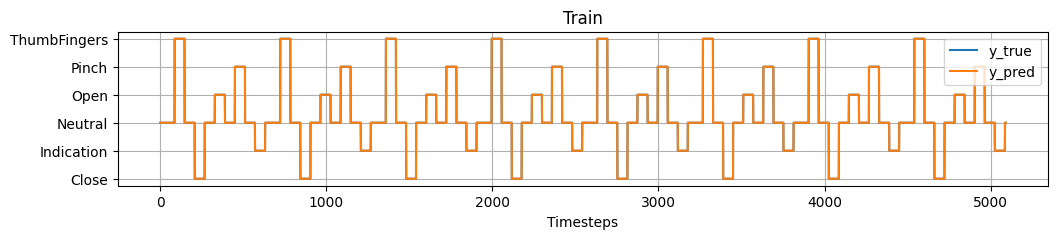

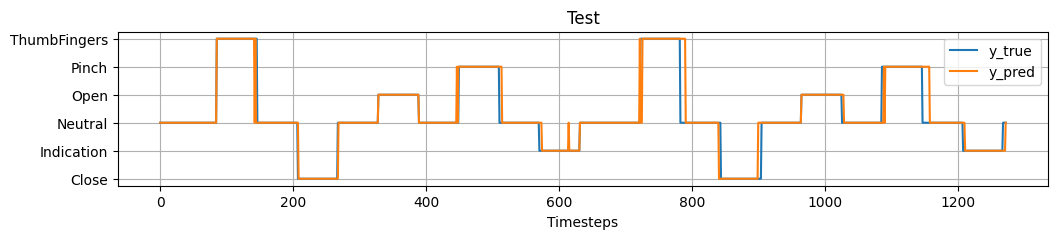

In [78]:
get_plots(preds_train_set1, preds_test_set1, y_train_set1, y_test_set1)

Получилось почти идеально.

### Модель для второго сета

In [79]:
# Инициализация модели
hgbc_set2 = ensemble.HistGradientBoostingClassifier(random_state=42)
# Распаковка сэмплов
X_train_set2, X_test_set2, y_train_set2, y_test_set2 = dictionaries[1]['es_norm_ax_ar']

# Обучение
hgbc_set2.fit(X_train_set2, y_train_set2)
# Предсказания
preds_train_set2 = hgbc_set2.predict(X_train_set2)
preds_test_set2 = hgbc_set2.predict(X_test_set2)
# Выво метрик
print(metrics.classification_report(
    y_test_set2, preds_test_set2, target_names=GESTURES, digits=4, zero_division=0))

              precision    recall  f1-score   support

       Close     0.9588    0.7623    0.8493       122
  Indication     0.9623    0.8430    0.8987       121
     Neutral     0.8520    0.9609    0.9032       665
        Open     0.9099    0.8347    0.8707       121
       Pinch     0.8000    0.7273    0.7619       121
ThumbFingers     0.9592    0.7705    0.8545       122

    accuracy                         0.8781      1272
   macro avg     0.9070    0.8164    0.8564      1272
weighted avg     0.8836    0.8781    0.8764      1272



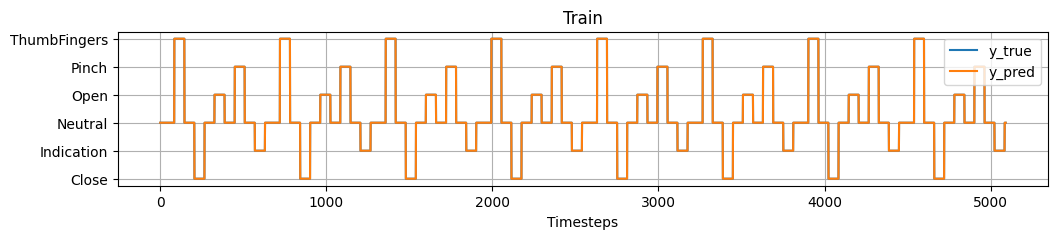

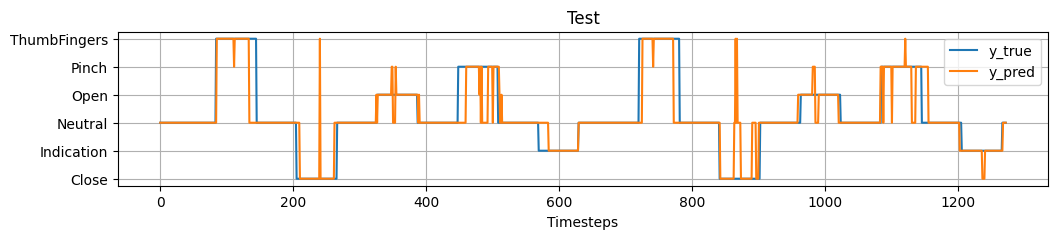

In [80]:
get_plots(preds_train_set2, preds_test_set2, y_train_set2, y_test_set2)

Здесь похуже. Но еще можно надеяться, что постпроцессинг на инференсе сможет хоть немного расчистить рисунок.

### Модель для третьего сета

In [81]:
# Инициализация модели
xgbc_set3 = xgb.XGBClassifier(seed=42, n_jobs=-1)
# Распаковка сэмплов
X_train_set3, X_test_set3, y_train_set3, y_test_set3 = dictionaries[2]['es_mm_ar_']

# Обучение
xgbc_set3.fit(X_train_set3, y_train_set3)
# Предсказания
preds_train_set3 = xgbc_set3.predict(X_train_set3)
preds_test_set3 = xgbc_set3.predict(X_test_set3)
# Выво метрик
print(metrics.classification_report(
    y_test_set3, preds_test_set3, target_names=GESTURES, digits=4, zero_division=0))

              precision    recall  f1-score   support

       Close     1.0000    0.8167    0.8991        60
  Indication     0.9825    0.9333    0.9573        60
     Neutral     0.9246    0.9625    0.9431       293
        Open     0.9242    1.0000    0.9606        61
       Pinch     0.9242    1.0000    0.9606        61
ThumbFingers     1.0000    0.8667    0.9286        60

    accuracy                         0.9429       595
   macro avg     0.9593    0.9299    0.9416       595
weighted avg     0.9456    0.9429    0.9422       595



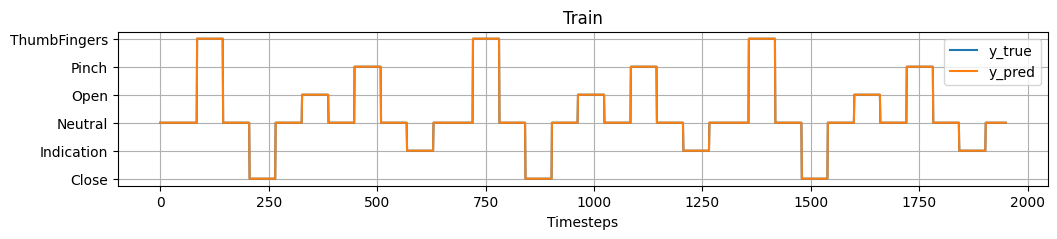

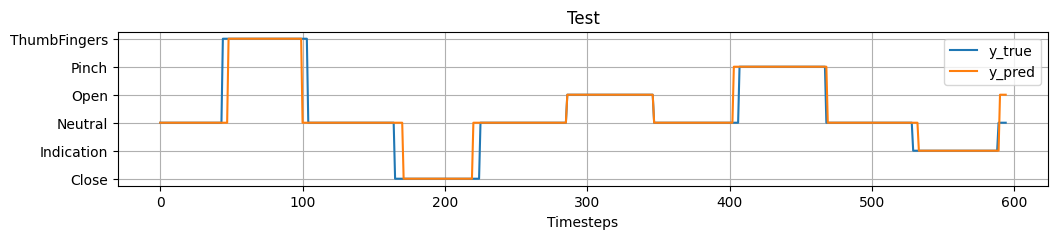

In [82]:
get_plots(preds_train_set3, preds_test_set3, y_train_set3, y_test_set3)

Очень хорошо! Разве что в самом конце небольшой промах.

---
## Оффлайн-инференс

### Утилиты инференса

Здесь, в зависимости от сета, в функции препроцессинга перед функцией инференса будут отрабатывать соответствующие методы предобработки.

Три типа предобработки на три сета:
1. data_mm_ar: коэффициенты авторегрессии, полученные с нормализованных min-max методом данных.
2. es_norm_ax_ar: комбинация коэффициентов регрессий с нормализованных данных со сглаживанием.
3. es_mm_ar_: сглаживание комбинации нормализованных min-max методом данных с коэффициентами авторегрессии.

Сперва нам надо предобучить нормализаторы.

In [92]:
# Вытягиваем треннировочную выборку исходных данных
original_train_set1 = dictionaries[0]['original_data'][0]
# Инициализируем нормализатор
mm_scaler_set1 = preprocessing.MinMaxScaler()
# Обучаем
mm_scaler_set1.fit(original_train_set1)

original_train_set2 = dictionaries[1]['original_data'][0]
norm_scaler_set2 = preprocessing.Normalizer()
norm_scaler_set2.fit(original_train_set2)

original_train_set3 = dictionaries[2]['original_data'][0]
mm_scaler_set3 = preprocessing.MinMaxScaler()
mm_scaler_set3.fit(original_train_set3)
print('')

In [137]:
def preprocessing(x, prev, sample_size=10, n_ftrs=5, alpha=0.5, set_number=1):
    if prev is None:
        prev = x.reshape(1, -1)
        
        if set_number == 1:
            prev_mm_set1 = mm_scaler_set1.transform(prev)
            prev_ar = get_ar_coefs(prev_mm_set1, p=n_ftrs)
            y = prev_ar
        elif set_number == 2:
            prev_norm_set2 = norm_scaler_set2.transform(prev)
            prev_approx = get_approx_lr_coefs(prev_norm_set2, n_ftrs=n_ftrs)
            prev_ar = get_ar_coefs(prev_norm_set2, p=n_ftrs)
            prev_ = np.hstack((prev_approx, prev_ar))
            y = prev_
        else:
            prev_mm_set3 = mm_scaler_set3.transform(prev)
            prev_ar = get_ar_coefs(prev, p=n_ftrs)
            prev_ = np.hstack((prev_mm_set3, prev_ar))
            y = prev_
            
    else:
        prev = np.vstack((prev, x.reshape(1, -1)))
        if prev.shape[0] < sample_size:
            
            if set_number == 1:
                prev_mm_set1 = mm_scaler_set1.transform(prev)
                prev_ar = get_ar_coefs(prev_mm_set1, p=n_ftrs)
                y = prev_ar[-1]
            elif set_number == 2:
                prev_norm_set2 = norm_scaler_set2.transform(prev)
                prev_approx = get_approx_lr_coefs(prev_norm_set2, n_ftrs=n_ftrs)
                prev_ar = get_ar_coefs(prev_norm_set2, p=n_ftrs)
                prev_ = np.hstack((prev_approx, prev_ar))
                y = get_smoothing(pd.DataFrame(prev_), sample_size=prev.shape[0], alpha=alpha)[-1]
            else:
                prev_mm_set3 = mm_scaler_set3.transform(prev)
                prev_ar = get_ar_coefs(prev, p=n_ftrs)
                prev_ = np.hstack((prev_mm_set3, prev_ar))
                y = get_smoothing(pd.DataFrame(prev_), sample_size=prev.shape[0], alpha=alpha)[-1]
                
        else:
            volume = sample_size + n_ftrs
            if prev.shape[0] < volume:
                prev = np.vstack((np.zeros((volume - prev.shape[0], prev.shape[1])), prev))
                appr_prev = prev[:n_ftrs]
                prev_x = prev[n_ftrs:]
            else:
                prev = prev[1:]
                appr_prev = prev[:n_ftrs]
                prev_x = prev[n_ftrs:]
            
            if set_number == 1:
                prev_mm_set1 = mm_scaler_set1.transform(prev_x)
                prev_ar = get_ar_coefs(prev_mm_set1, p=n_ftrs, prev=appr_prev)
                y = prev_ar[-1]
            elif set_number == 2:
                prev_norm_set2 = norm_scaler_set2.transform(prev_x)
                prev_approx = get_approx_lr_coefs(
                    prev_norm_set2, n_ftrs=5, prev=appr_prev)
                prev_ar = get_ar_coefs(prev_norm_set2, p=n_ftrs, prev=appr_prev)
                prev_ = np.hstack((prev_approx, prev_ar))
                y = get_smoothing(pd.DataFrame(prev_), sample_size=prev_x.shape[0], alpha=alpha)[-1]
            else:
                prev_mm_set3 = mm_scaler_set3.transform(prev_x)
                prev_ar = get_ar_coefs(prev_mm_set3, p=n_ftrs, prev=appr_prev)
                prev_ = np.hstack((prev_mm_set3, prev_ar))
                # y = get_smoothing(pd.DataFrame(prev_), sample_size=prev_x.shape[0], alpha=alpha)[-1]
                y = prev_[-1]

    return y.reshape(1, -1), prev


def inference(x, model=None):
    y = model.predict(x)
    
    return y


def postprocessing(x, prev, length=5):
    if prev is None:
        prev = np.zeros((length,))
        prev[0] = x
        prev = prev.astype(int)
        counts = np.bincount(prev)
        y = np.argmax(counts)
    else:
        prev[1:] = prev[:-1]
        prev[0] = x
        prev = prev.astype(int)
        counts = np.bincount(prev)
        y = np.argmax(counts)
        
    return y, prev


def commands(x):
    y = np.round(np.clip(x / 100, 0, 1)*100).astype(int)
    
    return y

### Инференс

Далее нам нужно подготовить исходные тестовые выборки.

In [103]:
_, test_orig_data_set1, _, target_set1 = dictionaries[0]['original_data']
_, test_orig_data_set2, _, target_set2 = dictionaries[1]['original_data']
_, test_orig_data_set3, _, target_set3 = dictionaries[2]['original_data']

tests = [test_orig_data_set1, test_orig_data_set2, test_orig_data_set3]
targets = [target_set1, target_set2, target_set3]
inference_models = [cbc_set1, hgbc_set2, xgbc_set3]

print(test_orig_data_set1.shape, target_set1.shape)
print(test_orig_data_set2.shape, target_set2.shape)
print(test_orig_data_set3.shape, target_set3.shape)

(1272, 50) (1272,)
(1272, 50) (1272,)
(595, 50) (595,)


In [98]:
# Отключаем предупреждения DeprecationWarning
warnings.filterwarnings("ignore", category=DeprecationWarning)

Текст предупреждения:<br>*DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)*

Строка кода, вызывающее предупреждение:<br>`prev[0] = x`

Далее мы выбираем номер сета.

In [143]:
SET_N = 1 # [1, 2, 3]

df_sim = tests[SET_N - 1]
MODEL = inference_models[SET_N - 1]
TARGET = targets[SET_N - 1]

И непосредственно инференс:

In [144]:
TIMEOUT = 0.033
LENGTH = 3
i = 0
ts_old = time.time()
ts_diff = 0;

ts_diffs = []
x_previous = None
y_previous = None
y_dct = {
    'omg_sample':[],
    'sample_preprocessed':[],
    
    'y_predicted':[],
    'y_postprocessed':[],
    'y_commands':[],
}
while True:    
    
    # [Data reading]
    ts_start = time.time()
    
    try:
        # [Sim data]
        if i < len(df_sim):
            omg_sample = df_sim[i]
        else:
            break
        
    except Exception as e:
        print(e)
        
    # [/Data Reading]
        
    # [Data preprocessing]
    sample_preprocessed, x_previous = preprocessing(omg_sample, x_previous, set_number=SET_N)
    # [/Data preprocessing]
    
    # [Inference]
    y_predicted = inference(sample_preprocessed, model=MODEL)
    # [/Inference]
    
    # [Inference Postprocessing]
    y_postprocessed, y_previous = postprocessing(y_predicted, y_previous, length=LENGTH)
    # [/Inference Postprocessing]
    
    # [Commands composition]
    y_commands = commands(y_postprocessed.argmax())
    # [/Commands composition]
    
    # [Commands sending]
    # NO COMMANDS SENDING IN SIMULATION
    # [/Commands sending]
    
    # [Data logging]
    y_dct['omg_sample'].append(omg_sample)
    y_dct['sample_preprocessed'].append(sample_preprocessed)
    y_dct['y_predicted'].append(y_predicted)
    y_dct['y_postprocessed'].append(y_postprocessed)
    y_dct['y_commands'].append(y_commands)
    # [/Data logging]

    ts_diff = time.time() - ts_start
    assert(ts_diff<TIMEOUT), f'Calculation cycle takes more than TIMEOUT, halting...\n{ts_diff}'
    ts_old = ts_start
    ts_diffs.append(ts_diff)
    i += 1 

#### Время на итерациях

Все модели смогли уложиться по времени.

Максимальное время на итерацию: 0.012872457504272461


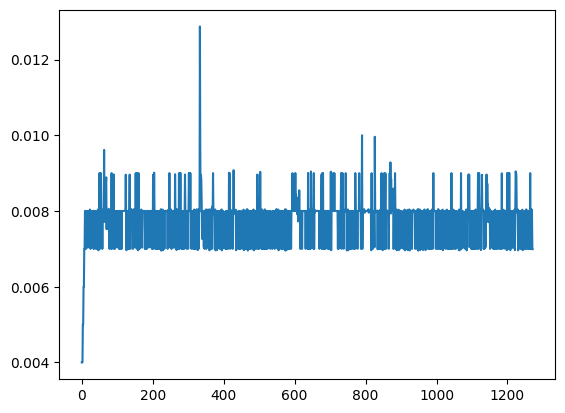

In [145]:
print('Максимальное время на итерацию:', np.max(ts_diffs))
pd.Series(ts_diffs).plot();

**Аналогичные показатели по второму сету:**

Максимальное время на итерацию: 0.021860599517822266

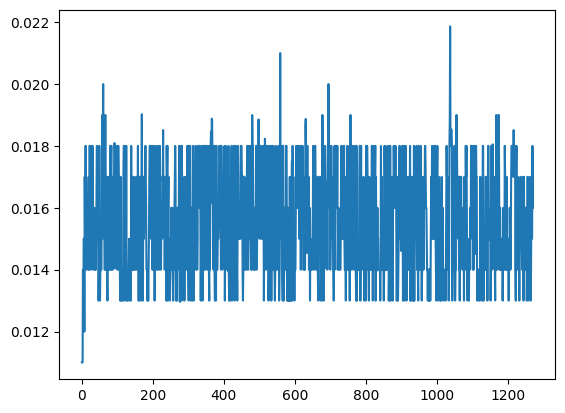

**Третий сет:**

Максимальное время на итерацию: 0.013998031616210938

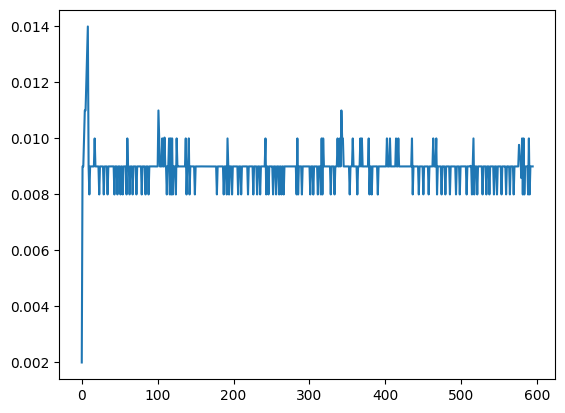

#### Графическое отображение предсказаний

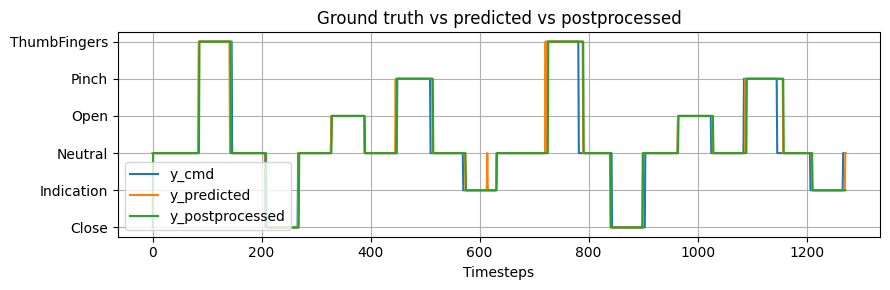

In [158]:
fig = plt.figure(figsize=(9, 3))

plt.plot(TARGET, c='C0', label='y_cmd')
plt.plot([y.reshape(-1) for y in y_dct['y_predicted']], c='C1', label='y_predicted')
plt.plot(y_dct['y_postprocessed'], c='C2', label='y_postprocessed')

plt.title('Ground truth vs predicted vs postprocessed')
plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.legend()
plt.grid()
plt.xlabel('Timesteps')

plt.tight_layout()

Получилось хорошо. Ошибку на жесте Indication удалось убрать.

**Предсказания для тестовой выборки второго сета:**

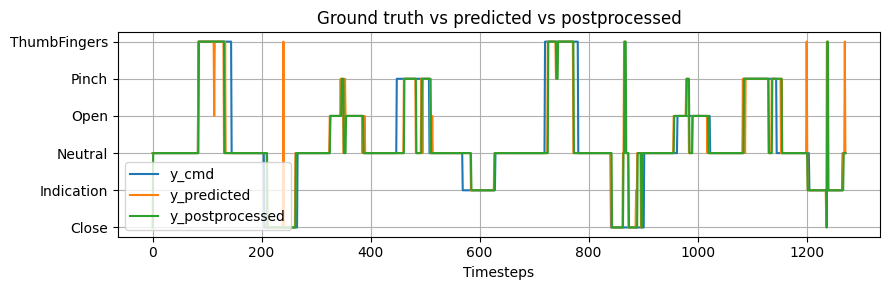

Удалось немного улучшить рисунок, но качество все так же не очень: избавиться от серьезных ошибок на этой стадии, разумеется, не получилось бы.

**Предсказания для тестовой выборки третьего сета:**

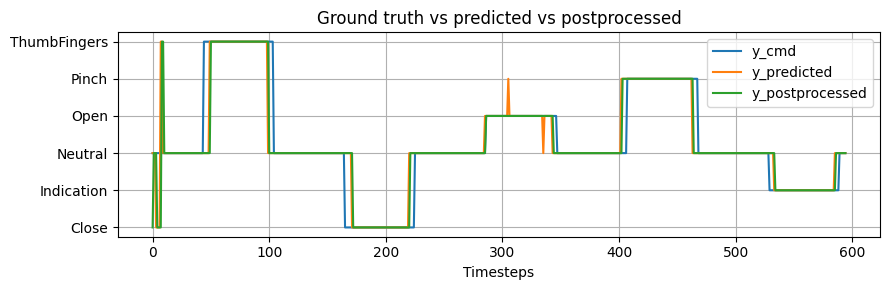

Видим всплеск в начале, но дальше все более менее. Пришлось на инференсе обойтись без функции сглаживания, т.к. она сильно портила предсказания.

#### Метрики

In [154]:
print(metrics.classification_report(
    TARGET, y_dct['y_postprocessed'],
    target_names=GESTURES, digits=4,
    zero_division=0
))

# создаём таблицу сопряжённости
ct = pd.crosstab(TARGET, np.array(y_dct['y_postprocessed']).reshape(-1))
if not list(ct.index) == list(ct.columns):
    set1, set2 = set(ct.index), set(ct.columns)
    diff = set1.difference(set2)
    if len(diff) == 1:
        specific_index = list(ct.index).index(list(diff)[0])
        new_column_name = str(diff)
        ct.insert(specific_index, new_column_name, 0)
        # определяем название активностей
        ct.index = ct.columns = GESTURES
        display(ct)
    else:
        print('Более чем один жест моделью не распознается!')
else:
    ct.index = ct.columns = GESTURES
    display(ct)

              precision    recall  f1-score   support

       Close     0.9583    0.9504    0.9544       121
  Indication     0.9492    0.9256    0.9372       121
     Neutral     0.9555    0.9353    0.9453       665
        Open     0.9600    0.9836    0.9717       122
       Pinch     0.8667    0.9590    0.9105       122
ThumbFingers     0.9268    0.9421    0.9344       121

    accuracy                         0.9434      1272
   macro avg     0.9361    0.9494    0.9422      1272
weighted avg     0.9443    0.9434    0.9435      1272



,Close,Indication,Neutral,Open,Pinch,ThumbFingers
Close,115,0,6,0,0,0
Indication,0,112,9,0,0,0
Neutral,5,6,622,5,18,9
Open,0,0,2,120,0,0
Pinch,0,0,5,0,117,0
ThumbFingers,0,0,7,0,0,114


**Метрики второго сета:**

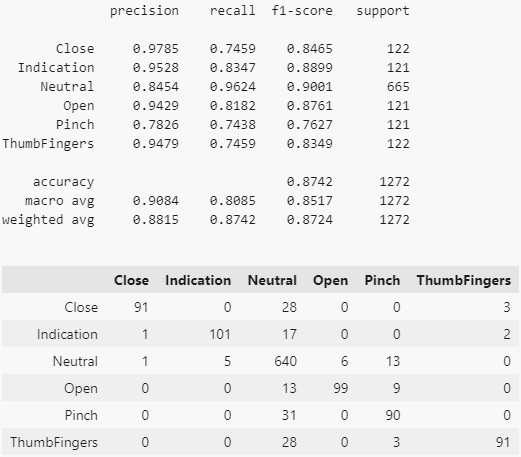

**Метрики третьего сета:**

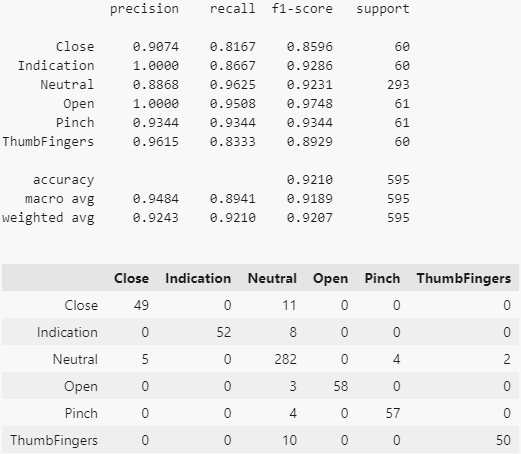

---
## Вывод

В этом ноутбуке мы снова опробовали наш метод, но на этот раз на новых данных из ОМГ-датчиков. Результаты можно счесть удовлетворительными, хоть и не удалось создать высококачественную модель для данных из второго сета. Причиной этого могут выступать — как качество самих данных, так и отсутствие адекватных методов предобработки среди использованных.

Была также предпринята попытка оптимизировать модели с помощью optuna, но ничем кроме лишнего упражнения в программировании это предприятие, увы, не стало: было бы больше данных... Но их столько, сколько мы имеем потому, что Моторика выяснила, что именно такой длительности записей часто бывает достаточно, чтобы насытить качественные модели. Впрочем, в двух из трех случаев мы в этом убедились.